In [325]:
import colorednoise as cn
from matplotlib import mlab
from matplotlib import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

import math
from collections import defaultdict

from scipy import signal
import scipy.stats as st
from scipy.signal import correlate, correlation_lags, detrend, coherence, welch, find_peaks

from sklearn.metrics import r2_score

import numpy as np
import gzip        
import pickle    
import pandas as pd


In [326]:
# Defining Functions
def mesh_index_to_km(x):
    return (x / 900) * 110

def mesh_index_to_m(x):
    return (x / 900) * 110000

def km_to_mesh_index(x):
    return (x / 110) * 900

def get_GL_index(gl_array):
    gl_array = np.array(gl_array).astype(int)
    for i in range(1, len(gl_array)):
        if gl_array[i-1] == 0 and gl_array[i] == 1:
            return i
    return None

def extract_near_terminus(var_dict, timesteps, gl_positions, offset_m, dx_m, nx, fill_value=np.nan):
    """
    Extract series of var(x,t) at a position offset_m upstream of the grounding line.
    - var_dict: dict keyed by timestep
    - timesteps: iterable of timesteps (same order as gl_positions)
    - gl_positions: array-like of GL mesh indices for each timestep
    - offset_m, dx_m: meters upstream and mesh spacing in meters
    - nx: number of mesh cells
    - fill_value: value to use when extraction is invalid
    """

    nearTerm_extract = []
    gl_idx_arr = np.array(gl_positions, dtype=float)
    offset_cells = int(round(offset_m / dx_m))

    for i, t in enumerate(timesteps):
        gl_idx = gl_idx_arr[i] if i < gl_idx_arr.size else np.nan

        if np.isnan(gl_idx) or gl_idx < offset_cells:
            nearTerm_extract.append(fill_value)
            continue
        target_idx = int(gl_idx) - offset_cells

        if not (0 <= target_idx < nx):
            nearTerm_extract.append(fill_value)
            continue
        row = var_dict.get(t, None)
        
        if row is None:
            nearTerm_extract.append(fill_value)
            continue
        val = row[target_idx]
        # preserve NaN if present; otherwise append numeric value
        nearTerm_extract.append(fill_value if (isinstance(val, float) and np.isnan(val)) else val)
    return np.array(nearTerm_extract, dtype=float)


def make_hovmoller(var_dict, timesteps, x_km, gl_positions, var_name, cmap='viridis', vmin=None, vmax=None, center_zero=False):
    """    
    Parameters:
    -----------
    var_dict : dict
        Dictionary with keys=timesteps, values=spatial arrays (length nx)
    timesteps : array-like
        Sorted array of timesteps
    x_km : array-like
        Spatial coordinate in km (length nx)
    gl_positions : array-like
        GL mesh indices for each timestep (same length as timesteps)
    var_name : str
        Name of variable for title/labels
    cmap : str
        Colormap name
    vmin, vmax : float
        Color scale limits (auto if None)
    """
    # Build matrix: rows=time, cols=space
    var_mat = np.array([np.asarray(var_dict[t]) if t in var_dict else np.full(len(x_km), np.nan) 
                        for t in timesteps])
    

    data_min = np.nanmin(var_mat)
    data_max = np.nanmax(var_mat)
    vmin = data_min if vmin is None else vmin
    vmax = data_max if vmax is None else vmax
    
    # Convert GL mesh indices to km
    gl_x_km = np.array([mesh_index_to_km(int(idx)) if not np.isnan(idx) else np.nan 
                        for idx in gl_positions])
    

    norm = None
    if center_zero:
        # White at 0 even if vmin/vmax are not symmetric
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)

    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    # pcm = ax.pcolormesh(x_km, timesteps, var_mat, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    pcm = ax.pcolormesh(x_km, timesteps, var_mat, shading='auto',
                        cmap=cmap, norm=norm, vmin=None if norm else vmin, vmax=None if norm else vmax)


    # Overlay grounding line
    ax.plot(gl_x_km, timesteps, 'black', lw=0.5, label='Grounding Line', zorder=10)
    
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Time (years)')
    ax.set_title(f'Hovmöller: {var_name}(x,t) with GL')
    ax.invert_yaxis()
    ax.legend(loc='upper right')
    
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(var_name)
    
    plt.tight_layout()
    return fig, ax, var_mat


def make_hovmoller_SMB(var_dict, timesteps, x_km, gl_positions, var_name,
                   cmap='viridis', vmin=None, vmax=None,
                   center_zero=True,
                   draw_zero_line=True,
                   zero_line_kwargs=None,
                   gl_kwargs=None):
    """
    Create a Hovmöller (x-time) plot with grounding line overlay and optional zero-level line.

    Parameters
    ----------
    var_dict : dict
        Dictionary with keys=timesteps, values=spatial arrays (length nx)
    timesteps : array-like
        Sorted array of timesteps (length nt)
    x_km : array-like
        Spatial coordinate in km (length nx)
    gl_positions : array-like
        GL mesh indices for each timestep (same length as timesteps)
    var_name : str
        Name of variable for title/labels
    cmap : str
        Colormap name (use diverging like 'seismic'/'seismic_r' for centered white)
    vmin, vmax : float
        Color scale limits (auto from data if None)
    center_zero : bool
        If True, use a diverging norm centered at 0 (white at 0)
    draw_zero_line : bool
        If True, overlay the SMB = 0 contour line
    zero_line_kwargs : dict
        Matplotlib style kwargs for the zero-level line (e.g., {'colors':'k','linewidths':1.2})
    gl_kwargs : dict
        Matplotlib style kwargs for the GL line (e.g., {'color':'black','lw':0.8})
    """
    # Build matrix: rows=time, cols=space
    var_mat = np.array([np.asarray(var_dict[t]) if t in var_dict else np.full(len(x_km), np.nan)
                        for t in timesteps])

    # Compute data-driven limits if not provided (ignore NaNs)
    data_min = np.nanmin(var_mat)
    data_max = np.nanmax(var_mat)
    vmin = data_min if vmin is None else vmin
    vmax = data_max if vmax is None else vmax

    # Convert GL mesh indices to km
    def _safe_mesh_index_to_km(idx):
        try:
            return mesh_index_to_km(int(idx))
        except Exception:
            return np.nan

    gl_x_km = np.array([_safe_mesh_index_to_km(idx) if not np.isnan(idx) else np.nan
                        for idx in gl_positions])

    # Choose normalization: white at 0 even if vmin/vmax not symmetric
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax) if center_zero else None

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    pcm = ax.pcolormesh(x_km, timesteps, var_mat, shading='auto',
                        cmap=cmap, norm=norm,
                        vmin=None if norm else vmin,
                        vmax=None if norm else vmax)

    # Overlay grounding line
    _glk = {'color': 'black', 'lw': 0.8, 'label': 'Grounding Line', 'zorder': 10}
    if gl_kwargs:
        _glk.update(gl_kwargs)
    ax.plot(gl_x_km, timesteps, **_glk)

    # Overlay zero-level contour (SMB = 0)
    if draw_zero_line:
        # Build coordinate grids for contour (requires 2D X, Y)
        X, Y = np.meshgrid(x_km, timesteps)
        _zk = {'colors': 'k', 'linewidths': 1.2, 'alpha': 0.9, 'zorder': 12}
        if zero_line_kwargs:
            _zk.update(zero_line_kwargs)
        try:
            cs = ax.contour(X, Y, var_mat, levels=[0.0], **_zk)
            # Optional legend entry for zero line
            # Only add label if not already present
            ax.plot([], [], color=_zk.get('colors', 'k'),
                    lw=_zk.get('linewidths', 1.2),
                    label='ELA (x-pos)')
        except Exception:
            # If contour fails due to NaNs or degenerate levels, skip gracefully
            pass

    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Time (years)')
    ax.set_title(f'Hovmöller: {var_name}(x,t) with GL')
    ax.invert_yaxis()
    ax.legend(loc='upper right')

    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(var_name)

    plt.tight_layout()
    return fig, ax, var_mat



## Loading Data

In [327]:
# variable = "NoiseRNG(5)_ClimateChange(0_05)"
runName = "AminNoise_Seed121"
runTime = "10ka"

#################################################################################################################################
# Main Path
noise_path = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_11_12__11_33_44.pkl.gz"
with gzip.open(noise_path, 'rb') as f:
    DATA_dict = pickle.load(f)

# Reference Path
base_path = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_11_17__12_32_49.pkl.gz"
with gzip.open(base_path, 'rb') as f:
    DATA_dict_base = pickle.load(f)

#################################################################################################################################
NoiseData = np.loadtxt(
    "/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/10ka_noiseTests/CSVs/amin_amax_timeseries_amp1.0_10000yrs_RNG(121)_amin_10ka.csv",
    delimiter=",",
    skiprows=1  
)

In [328]:
### Model parameters ###
nx = 900
L = 55000.0

# Mesh Domain
x_m = np.linspace(0, 2*L, nx)            # m
x_km = np.linspace(0, 2*L, nx) / 1000.0   # km

# Mesh cell size
dx_km = x_km[-1] / nx
dx_m  = x_m[-1] / nx  

thklim = 1.0                    # minimum ice thickness in model 

print(f"# of Mesh Cells: {nx}")
print(f"Domain Length: {x_m[-1]} m")
print(f"Domain Length: {x_km[-1]} km")
print(f"Mesh Cell Size: {dx_m:.2f} m")
print(f"Mesh Cell Size: {dx_km:.2f} km")

# of Mesh Cells: 900
Domain Length: 110000.0 m
Domain Length: 110.0 km
Mesh Cell Size: 122.22 m
Mesh Cell Size: 0.12 km


In [329]:
# Noise DATA Dictionary
bed_dict = DATA_dict['bed_dict']
base_dict = DATA_dict['base_dict']
surf_dict = DATA_dict['surf_dict']
sed_dict = DATA_dict['sed_dict']
H_dict = DATA_dict['H_dict']
us_dict = DATA_dict['us_dict']
ub_dict = DATA_dict['ub_dict']
Hs_dict = DATA_dict['Hs_dict']
GL_dict = DATA_dict['GL_dict']
Qs_dict = DATA_dict['Qs_dict']
SMB_dict = DATA_dict['SMB_dict']
counter_dict = DATA_dict['counter_dict']

Pw_dict = DATA_dict['Pw_dict']
N_dict = DATA_dict['N_dict']
me_dict = DATA_dict['me_dict']
Qw_dict = DATA_dict['Qw_dict']
Bdot_dict = DATA_dict['Bdot_dict']
edot_dict = DATA_dict['edot_dict']
ddot_dict = DATA_dict['ddot_dict']
beta_dict = DATA_dict['beta_dict']

timesteps_noise = np.array(list(us_dict.keys()))
mesh_indices = np.arange(len(us_dict[timesteps_noise[0]]))
data_matrix = np.array([us_dict[t] for t in timesteps_noise])

threshold = 0.06  
gl_positions = []

# Extract GL Positions
for t in timesteps_noise:
    us = np.array(us_dict[t])
    ub = np.array(ub_dict[t])
    
    # Find where |us - ub| < tol
    diff = np.abs(us - ub)
    equal_points = np.where(diff < threshold)[0]

    if len(equal_points) == 0:
        gl_positions.append(np.nan)
        continue

    valid_points = equal_points[equal_points >= 1]

    if len(valid_points) == 0:
        gl_positions.append(np.nan)
        continue

    gl_positions.append(valid_points[0])
    
# Convert GL positions to KM     
GL_Noisy_km = mesh_index_to_km(np.array(gl_positions))

# Find Peaks, Troughs, and Period of Cycles 
peaks, _ = find_peaks(GL_Noisy_km, prominence=1, height=20, distance=100)
peaktimes = timesteps_noise[peaks]

troughs, _ = find_peaks(-GL_Noisy_km, prominence=2, distance=200)
troughs = troughs[GL_Noisy_km[troughs] < 60]  
troughtimes = timesteps_noise[troughs]

periods    = np.diff(np.array(timesteps_noise)[peaks])
adv_dists  = GL_Noisy_km[peaks]
ret_dists  = GL_Noisy_km[troughs]

# Extract Data from CSV
timesteps_csv = NoiseData[:,0]
noisy_amin_series = NoiseData[:,1]
noisy_amax_series = NoiseData[:,2]

dt_1 = np.mean(np.diff(timesteps_csv))
freqs_amin1, Pxx_amin1 = welch(noisy_amin_series, fs=1.0/dt_1, nperseg=min(256, len(noisy_amin_series)))
freqs_amax1, Pxx_amax1 = welch(noisy_amax_series, fs=1.0/dt_1, nperseg=min(256, len(noisy_amax_series)))


In [330]:
# Base DATA Dictionary
bed_dictBase = DATA_dict_base['bed_dict']
base_dictBase = DATA_dict_base['base_dict']
surf_dictBase = DATA_dict_base['surf_dict']
sed_dictBase = DATA_dict_base['sed_dict']
H_dictBase = DATA_dict_base['H_dict']
us_dictBase = DATA_dict_base['us_dict']
ub_dictBase = DATA_dict_base['ub_dict']
Hs_dictBase = DATA_dict_base['Hs_dict']
GL_dictBase = DATA_dict_base['GL_dict']
Qs_dictBase = DATA_dict_base['Qs_dict']
SMB_dictBase = DATA_dict_base['SMB_dict']
counter_dictBase = DATA_dict_base['counter_dict']

Pw_dict_Base = DATA_dict_base['Pw_dict']
N_dict_Base = DATA_dict_base['N_dict']
me_dict_Base = DATA_dict_base['me_dict']
Uw_dict_Base = DATA_dict_base['Uw_dict']
Bdot_dict_Base = DATA_dict_base['Bdot_dict']
edot_dict_Base = DATA_dict_base['edot_dict']
ddot_dict_Base = DATA_dict_base['ddot_dict']

timeBase_raw = np.array(list(us_dictBase.keys()))
timesteps_Base = timeBase_raw - 2950  # Adjust time to align with noisy run
timesteps_Base=np.array(timesteps_Base)
mesh_indicesBase = np.arange(len(us_dictBase[timeBase_raw[0]]))
data_matrixBase = np.array([us_dictBase[t] for t in timeBase_raw])

# timeBase_raw_12950 = np.array(list(us_dictBase.keys()))
# mask_post2950 = timeBase_raw_12950 >= 2950  # Adjust time to align with noisy run
# timeBase_raw = np.sort(timeBase_raw_12950[mask_post2950])

threshold = 0.05  # meters, or whatever your model units are
gl_positionsBase = []

# Extract GL Positions
for t in timeBase_raw:
    us = np.array(us_dictBase[t])
    ub = np.array(ub_dictBase[t])
    
    # Find where |us - ub| < tol
    diff = np.abs(us - ub)
    equal_points = np.where(diff < threshold)[0]

    if len(equal_points) == 0:
        gl_positionsBase.append(np.nan)
        continue

    # The grounding line = first point where they are equal moving downstream
    gl_positionsBase.append(equal_points[0])

# Convert to KM     
GL_kmBase = mesh_index_to_km(np.array(gl_positionsBase))

# Find Peaks, Troughs, and Period of Cycles 
peaksBase, _   = find_peaks(GL_kmBase, prominence=5)
troughsBase, _ = find_peaks(-GL_kmBase, prominence=5)

periodsBase    = np.diff(np.array(timesteps_Base)[peaksBase])
adv_distsBase  = GL_kmBase[peaksBase]
ret_distsBase  = GL_kmBase[troughsBase]

In [331]:
### Extracting Near Terminus Variables ###
offset_m = 1500     # Distance upstream from terminus to extract values

# Extraction from Noise runs
term_H   = extract_near_terminus(H_dict, timesteps_noise, gl_positions, offset_m, dx_m, nx, fill_value=np.nan)
term_us  = extract_near_terminus(us_dict, timesteps_noise, gl_positions, offset_m, dx_m, nx, fill_value=np.nan)
term_ub  = extract_near_terminus(ub_dict, timesteps_noise, gl_positions, offset_m, dx_m, nx, fill_value=np.nan)
term_Pw  = extract_near_terminus(Pw_dict, timesteps_noise, gl_positions, offset_m, dx_m, nx, fill_value=np.nan)
term_N   = extract_near_terminus(N_dict, timesteps_noise, gl_positions, offset_m, dx_m, nx, fill_value=np.nan)
term_me  = extract_near_terminus(me_dict, timesteps_noise, gl_positions, offset_m, dx_m, nx, fill_value=np.nan)
max_Qs = np.array([np.max(values) for values in Qs_dict.values()])

term_Qw  = extract_near_terminus(Qw_dict, timesteps_noise, gl_positions, offset_m, dx_m, nx, fill_value=np.nan)
term_Bdot= extract_near_terminus(Bdot_dict, timesteps_noise, gl_positions, offset_m, dx_m, nx, fill_value=np.nan)
term_Edot= extract_near_terminus(edot_dict, timesteps_noise, gl_positions, offset_m, dx_m, nx, fill_value=np.nan)
term_Ddot= extract_near_terminus(ddot_dict, timesteps_noise, gl_positions, offset_m, dx_m, nx, fill_value=np.nan)

# Extraction from Base run
term_H_base    = extract_near_terminus(H_dictBase, timeBase_raw, gl_positionsBase, offset_m, dx_m, nx, fill_value=np.nan)
term_us_base   = extract_near_terminus(us_dictBase, timeBase_raw, gl_positionsBase, offset_m, dx_m, nx, fill_value=np.nan)
term_ub_base   = extract_near_terminus(ub_dictBase, timeBase_raw, gl_positionsBase, offset_m, dx_m, nx, fill_value=np.nan)
term_Pw_base   = extract_near_terminus(Pw_dict_Base, timeBase_raw, gl_positionsBase, offset_m, dx_m, nx, fill_value=np.nan)
term_N_base    = extract_near_terminus(N_dict_Base, timeBase_raw, gl_positionsBase, offset_m, dx_m, nx, fill_value=np.nan)
term_me_base   = extract_near_terminus(me_dict_Base, timeBase_raw, gl_positionsBase, offset_m, dx_m, nx, fill_value=np.nan)
max_Qs_base = np.array([np.max(values) for values in Qs_dictBase.values()])

term_Uw_base   = extract_near_terminus(Uw_dict_Base, timeBase_raw, gl_positionsBase, offset_m, dx_m, nx, fill_value=np.nan)
term_Bdot_base = extract_near_terminus(Bdot_dict_Base, timeBase_raw, gl_positionsBase, offset_m, dx_m, nx, fill_value=np.nan)
term_Edot_base = extract_near_terminus(edot_dict_Base, timeBase_raw, gl_positionsBase, offset_m, dx_m, nx, fill_value=np.nan)
term_Ddot_base = extract_near_terminus(ddot_dict_Base, timeBase_raw, gl_positionsBase, offset_m, dx_m, nx, fill_value=np.nan)


## GL Plot w/ Comparison to Amin and Amax over time

In [332]:
# Calculating running mean for amin and amax
mean_window = 101

# Calculate running mean 
series = pd.Series(noisy_amin_series, index=timesteps_csv)
rm_amin = series.rolling(window = mean_window, center = True, min_periods=1).mean()

series = pd.Series(noisy_amax_series, index=timesteps_csv)
rm_amax = series.rolling(window = mean_window, center = True, min_periods=1).mean()

# Calculate Slope of Running Mean
d_amin = np.gradient(rm_amin, timesteps_csv)
d_amax = np.gradient(rm_amax, timesteps_csv)

# Assign color based on increasing or decreasing slope of runnning mean
color_incAmin = 'darkred'
color_decAmin = 'orangered'

color_incAmax = 'darkblue'
color_decAmax = 'dodgerblue'

def plot_colored_line(ax, x, y, dy, color_up, color_down, linewidth=1):
    x = np.asarray(x)
    y = np.asarray(y)
    dy = np.asarray(dy)

    for i in range(len(x) - 1):
        c = color_up if dy[i] >= 0 else color_down
        ax.plot(x[i:i+2], y[i:i+2], color=c, lw=linewidth)

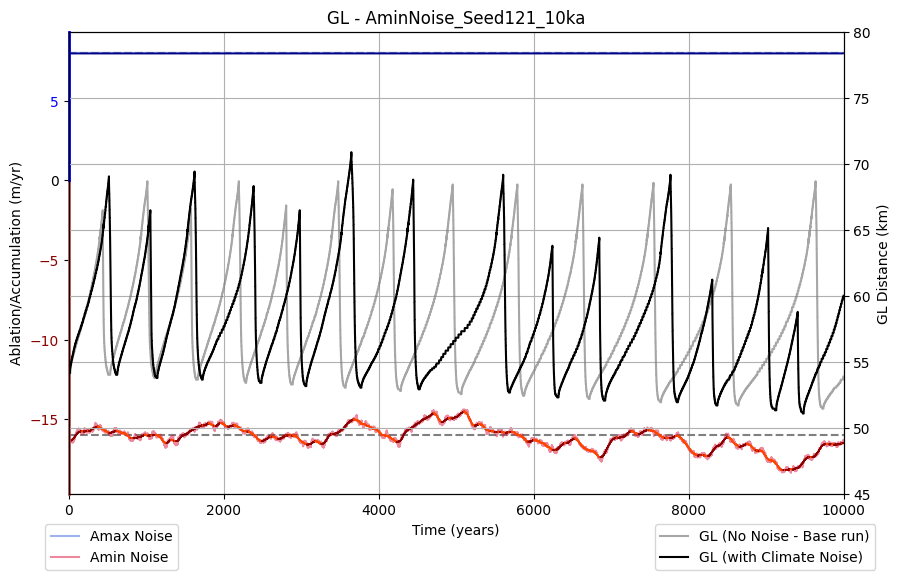

/tmp/ipykernel_1690019/2113203748.py:55: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_movingAVG.png", format ="png", bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

# Base values of accumulation and ablation
ax.axhline(y=-16, linestyle = '--', color = 'grey')
ax.axhline(y=8, linestyle = '--', color = 'grey')

# Accumulation
ax.plot(timesteps_csv, noisy_amax_series, color = 'royalblue', alpha = 0.5, label = 'Amax Noise')
plot_colored_line(ax, timesteps_csv, rm_amax, d_amax, color_incAmax, color_decAmax)

# Ablation
ax.plot(timesteps_csv, noisy_amin_series, color = 'crimson', alpha = 0.5, label = 'Amin Noise')
plot_colored_line(ax, timesteps_csv, rm_amin, d_amin, color_incAmin, color_decAmin)

# GL position plotting
ax2 = ax.twinx()

ax2.plot(timesteps_Base, GL_kmBase, color = 'gray', label = 'GL (No Noise - Base run)', alpha = 0.7)
ax2.plot(timesteps_noise, GL_Noisy_km, color = 'black', label = 'GL (with Climate Noise)')

# Plot Settings
ax.set_xlabel("Time (years)")
ax.set_ylabel("Ablation/Accumulation (m/yr)")
ax2.set_ylabel("GL Distance (km)")
plt.title(f"GL - {runName}_{runTime}")

ax.set_xlim(0,10000)
ax2.set_ylim(45,80)

ax2.grid(axis='both')
ax.grid(axis='x')
ax.legend(bbox_to_anchor=(.15, -0.05))
ax2.legend(bbox_to_anchor=(1.05, -0.05))

# Coloring the Axis 
fig.canvas.draw()
yticks = ax.get_yticks()
ymin, ymax = ax.get_ylim()
xpos = ax.get_xlim()[0]

ax.axvline(x=xpos, ymin=0, ymax=(0 - ymin)/(ymax - ymin), color='indianred', lw=2, clip_on=False)
ax.axvline(x=xpos, ymin=(0 - ymin)/(ymax - ymin), ymax=1, color='blue', lw=2, clip_on=False)

for tick, val in zip(ax.get_yticklabels(), yticks):
    if val > 0:
        tick.set_color('blue')
    elif val < 0:
        tick.set_color('darkred')
    else:
        tick.set_color('black')

plt.show()

# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_movingAVG.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_movingAVG.png", format ="png", bbox_inches='tight')

# Summary Plot

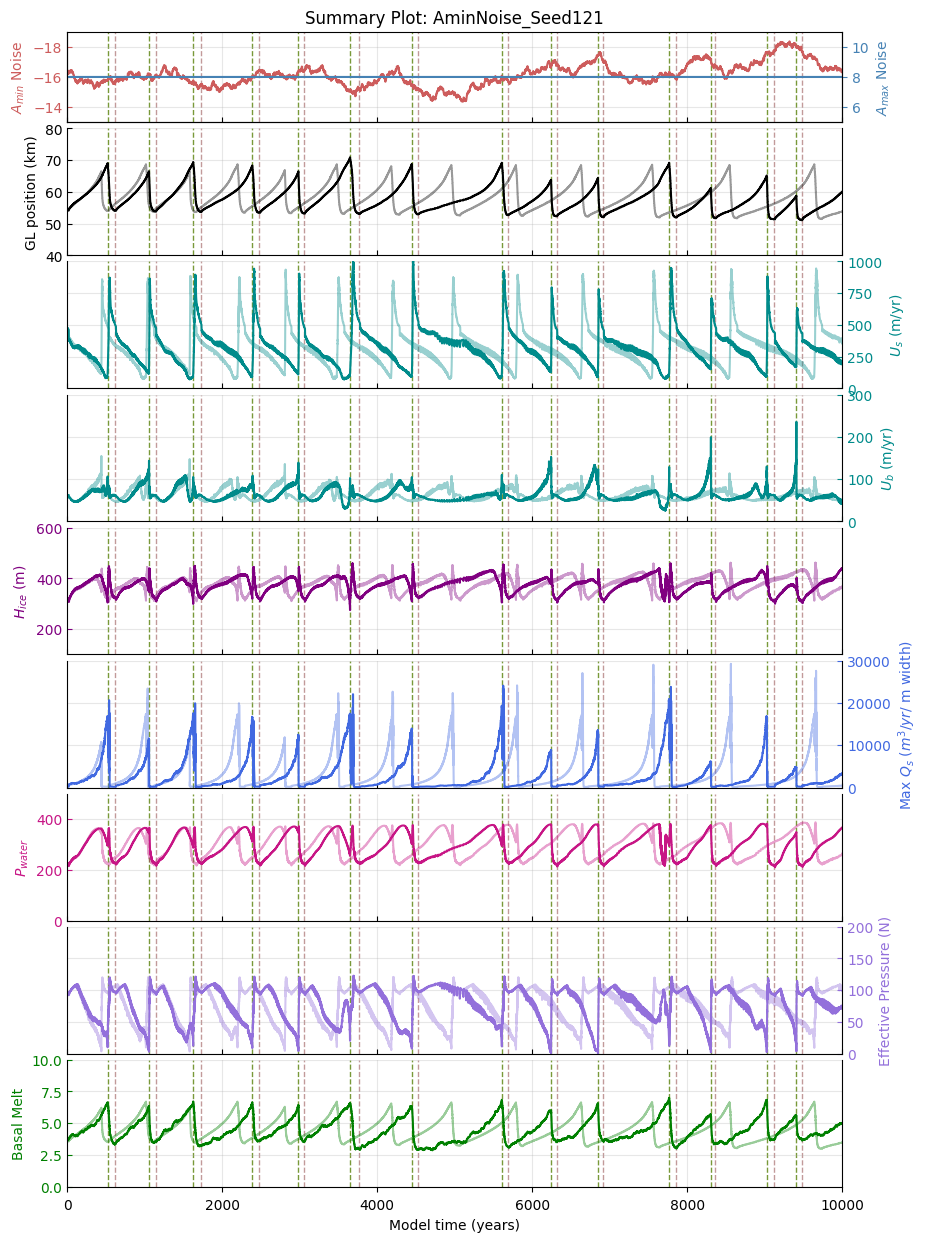

In [ ]:
fig = plt.figure(figsize=(10,15))
gs = GridSpec(9, 1, height_ratios=[1, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4], hspace=0.05)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax0)
ax3 = fig.add_subplot(gs[3], sharex=ax0)
ax4 = fig.add_subplot(gs[4], sharex=ax0)
ax5 = fig.add_subplot(gs[5], sharex=ax0)
ax6 = fig.add_subplot(gs[6], sharex=ax0)
ax7 = fig.add_subplot(gs[7], sharex=ax0)
ax8 = fig.add_subplot(gs[8], sharex=ax0)


# === Climate noise ===
ax0.plot(timesteps_csv, noisy_amin_series, color='indianred')
ax0.set_ylim(-13,-19)

ax0r = ax0.twinx()
ax0r.plot(timesteps_csv, noisy_amax_series, color='steelblue')
ax0r.set_ylim(5,11, auto = False)

ax0.set_ylabel('$A_{min}$ Noise', color='indianred')
ax0.tick_params(axis='y', colors='indianred')
ax0r.set_ylabel('$A_{max}$ Noise', color='steelblue')
ax0r.tick_params(axis='y', colors='steelblue')

# === GL plot ===
ax1.plot(timesteps_Base, GL_kmBase, color='black', alpha=0.4)
ax1.plot(timesteps_noise, GL_Noisy_km, color='black')
ax1.set_ylabel('GL position (km)', color='black')
ax1.set_ylim(40, 80)
ax1.tick_params(axis='y', colors='black')

# === Surface Velocity plot ===
ax2.plot(timesteps_Base, term_us_base, color='darkcyan', alpha=0.4)
ax2.plot(timesteps_noise, term_us, color='darkcyan')
ax2.set_ylabel('$U_s$ (m/yr)', color='darkcyan')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.set_ylim(0,1000)
ax2.tick_params(axis='y', colors='darkcyan')

# === Basal Velocity plot ===
ax3.plot(timesteps_Base, term_ub_base, color='darkcyan', alpha=0.4)
ax3.plot(timesteps_noise, term_ub, color='darkcyan')
ax3.set_ylabel('$U_b$ (m/yr)', color='darkcyan')
ax3.yaxis.set_label_position('right')
ax3.yaxis.tick_right()
ax3.set_ylim(0,300)
ax3.tick_params(axis='y', colors='darkcyan')

# === Thickness plot ===
ax4.plot(timesteps_Base, term_H_base, color='purple', alpha=0.4)
ax4.plot(timesteps_noise, term_H, color='purple')
ax4.set_ylabel('$H_{ice}$ (m)', color='purple')
ax4.tick_params(axis='y', colors='purple')
ax4.set_ylim(100, 600)

# === Qs plot ===
ax5.plot(timesteps_Base, max_Qs_base, color='royalblue', alpha=0.4)
ax5.plot(timesteps_noise, max_Qs, color='royalblue')
ax5.set_ylabel('Max $Q_s$ ($m^3/yr$/ m width)', color='royalblue')
ax5.yaxis.set_label_position('right')
ax5.yaxis.tick_right()
ax5.set_ylim(0,30000)
ax5.tick_params(axis='y', colors='royalblue')

# === Pw plot ===
ax6.plot(timesteps_Base, term_Pw_base, color = 'mediumvioletred', alpha = 0.4)
ax6.plot(timesteps_noise, term_Pw, color = 'mediumvioletred')
ax6.set_ylabel('$P_{water}$', color='mediumvioletred')
ax6.set_ylim(0,500)
ax6.tick_params(axis='y', colors='mediumvioletred')


# === Effective Pressure plot ===
ax7.plot(timesteps_Base, term_N_base, color = 'mediumpurple', alpha = 0.4)
ax7.plot(timesteps_noise, term_N, color = 'mediumpurple')
ax7.set_ylabel('Effective Pressure (N)', color='mediumpurple')
ax7.set_ylim(0,200)
ax7.yaxis.set_label_position('right')
ax7.yaxis.tick_right()
ax7.tick_params(axis='y', colors='mediumpurple')

# === Melt plot ===
ax8.plot(timesteps_Base, term_me_base, color = 'green', alpha = 0.4)
ax8.plot(timesteps_noise, term_me, color = 'green')
ax8.set_ylabel('Basal Melt', color='green')
ax8.set_ylim(0,10)
ax8.tick_params(axis='y', colors='green')

for a in [ax0, ax1, ax2, ax3, ax4, ax5, ax6,ax7, ax8]:
    a.spines['top'].set_visible(False)
    a.grid(axis = 'both', alpha=0.3)
    a.set_xlim(0,10000)
    a.tick_params(direction='in')
    for t in peaktimes:
        a.axvline(x=t, color='olivedrab', lw=1, ls='--', alpha=0.9, zorder=0)
    for t in troughtimes:
        a.axvline(x=t, color='rosybrown', lw=1, ls='--', alpha=0.9, zorder=0)

for a in [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]:
    plt.setp(a.get_xticklabels(), visible=False)

ax0.set_title(f"Summary Plot: {runName}")
ax8.tick_params(axis='x', which='both', pad=5, direction='out')
ax8.set_xlabel('Model time (years)')

plt.show()

# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_SummaryPlot_Full.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_SummaryPlot_Full.png", format ="png", bbox_inches='tight')

# Degree Change Attempt

In [335]:
# Noisy SMB Ablation Extraction
ELA_idx = {}
GL_idx = {}

NEG_b_n = {}
NEG_B_n = {}
NEG_B_n_avg = {}

POS_b_n = {}
POS_B_n = {}
POS_B_n_avg = {}

timestepsSMB = sorted(list(SMB_dict.keys()))

for i, t in enumerate(timestepsSMB):

    smb = np.asarray(SMB_dict[t], dtype=float)

    # ELA index 
    ela_i = int(np.nanargmin(np.abs(smb)))
    ELA_idx[t] = ela_i

    # Accumulation Area
    acc_slice = smb[0:ela_i]
    accum_cells = acc_slice[acc_slice > 0]

    # Extract positive SMB = accumulation values
    POS_b_n[t] = accum_cells
    POS_B_n[t] = np.sum(accum_cells) if accum_cells.size > 0 else 0.0
    POS_B_n_avg[t] = POS_B_n[t] * (dx_m / (mesh_index_to_m(len(accum_cells))))


    # GL index 
    gl_i = gl_positions[i]
    if np.isnan(gl_i):
        GL_idx[t] = np.nan
        NEG_b_n[t] = np.array([np.nan])
        NEG_B_n[t] = np.nan
        continue

    gl_i = int(gl_i)
    GL_idx[t] = gl_i

    # avoid negative slicing
    if gl_i < 0 or gl_i >= len(smb):
        NEG_b_n[t] = np.array([np.nan])
        NEG_B_n[t] = np.nan
        continue

    # Ablation zone slice 
    start, stop = sorted((ela_i, gl_i))

    # Slice SMB over ELA → GL
    abl_slice = smb[start:stop+1]

    # Extract negative SMB = melt values
    melt_cells = abl_slice[abl_slice < 0]

    NEG_b_n[t] = melt_cells
    NEG_B_n[t] = np.sum(melt_cells) if melt_cells.size > 0 else 0.0
    NEG_B_n_avg[t] = NEG_B_n[t] * (dx_m / (mesh_index_to_m(len(melt_cells))))



In [336]:
# Base SMB Ablation Extraction
ELA_idx_base = {}
GL_idx_base = {}

NEG_b_n_base = {}
NEG_B_n_base = {}
NEG_B_n_avg_base = {}

POS_b_n_base = {}
POS_B_n_base = {}
POS_B_n_avg_base = {}

timestepsSMB_Base = list(SMB_dictBase.keys())

for i, t in enumerate(timestepsSMB_Base):

    smb_base = np.asarray(SMB_dictBase[t], dtype=float)

    # ELA index 
    ela_i_base = int(np.nanargmin(np.abs(smb_base)))
    ELA_idx_base[t] = ela_i_base

    # Accumulation Area
    acc_slice_base = smb_base[0:ela_i_base+1]
    accum_cells_base = acc_slice_base[acc_slice_base > 0]

    # Extract positive SMB = accumulation values
    POS_b_n_base[t] = accum_cells_base
    POS_B_n_base[t] = np.sum(accum_cells_base) if accum_cells_base.size > 0 else 0.0
    POS_B_n_avg_base[t] = POS_B_n_base[t] * (dx_m / (mesh_index_to_m(len(accum_cells_base))))

    # GL index 
    gl_i_base = gl_positionsBase[i]
    if np.isnan(gl_i_base):
        GL_idx_base[t] = np.nan
        NEG_b_n_base[t] = np.array([np.nan])
        NEG_B_n_base[t] = np.nan
        continue

    gl_i_base = int(gl_i_base)
    GL_idx_base[t] = gl_i_base

    # avoid negative slicing
    if gl_i_base < 0 or gl_i_base >= len(smb_base):
        NEG_b_n_base[t] = np.array([np.nan])
        NEG_B_n_base[t] = np.nan
        continue

    # --- Ablation zone slice ---
    start, stop = sorted((ela_i_base, gl_i_base))

    # Slice SMB over ELA → GL
    abl_slice_base = smb_base[start:stop+1]

    # Extract negative SMB = melt values
    melt_cells_base = abl_slice_base[abl_slice_base < 0]

    NEG_b_n_base[t] = melt_cells_base
    NEG_B_n_base[t] = np.sum(melt_cells_base) if melt_cells_base.size > 0 else 0.0
    if melt_cells_base.size > 0:
        NEG_B_n_avg_base[t] = NEG_B_n_base[t] * (dx_m / (mesh_index_to_m(len(melt_cells_base))))
    else:
        NEG_B_n_avg_base[t] = 0.0

In [337]:
def plot_ablation_zone_with_geometry(i):
    """
    Visualize SMB extraction (accumulation + ablation zones) 
    and glacier profile at timestep i.
    i = index into sorted timesteps list.
    """

    t = timesteps_noise[i]
    smb = np.asarray(SMB_dict[t], dtype=float)

    ela_i = ELA_idx[t]
    gl_i  = GL_idx[t]

    surf = np.asarray(surf_dict[t], dtype=float)
    base = np.asarray(base_dict[t], dtype=float)

    x = np.arange(len(smb))

    fig, ax1 = plt.subplots(figsize=(10,4))

    # --- SMB curve (primary axis) ---
    ax1.plot(x, smb, color="black", linewidth=1, label="SMB")
    ax1.axhline(0, color="gray", linewidth=0.8)

    # --- ELA vertical line ---
    ax1.axvline(ela_i, color="blue", linestyle="--", label="ELA")

    # ================================
    #     NEW: ACCUMULATION SHADE
    # ================================
    acc_slice = smb[:ela_i+1]

    ax1.fill_between(
        x[:ela_i+1],
        acc_slice,
        0,
        where=(acc_slice > 0),
        color="deepskyblue",
        alpha=0.25,
        label="Accumulation (SMB > 0)"
    )

    # scatter positive SMB points
    pos_mask = smb > 0
    ax1.scatter(
        x[pos_mask],
        smb[pos_mask],
        color="deepskyblue",
        s=20,
        alpha=0.8,
        label="pos SMB cells"
    )
    # =================================


    # --- GL marker + ablation zone ---
    if not np.isnan(gl_i):
        gl_i = int(gl_i)
        ax1.axvline(gl_i, color="red", linestyle="--", label="Grounding line")

        start, stop = sorted((ela_i, gl_i))
        abl_slice = smb[start:stop+1]

        # Shaded negative SMB region
        ax1.fill_between(
            x[start:stop+1],
            abl_slice,
            0,
            where=(abl_slice < 0),
            color="orange",
            alpha=0.4,
            label="Ablation melt (SMB < 0)"
        )

        # Scatter negative SMB points
        neg_mask = smb < 0
        ax1.scatter(
            x[neg_mask],
            smb[neg_mask],
            color="red",
            s=25,
            label="neg SMB cells"
        )

    ax1.set_xlabel("Mesh index")
    ax1.set_ylabel("SMB (m/yr)")
    ax1.grid(alpha=0.3)

    # --- Glacier geometry on secondary axis ---
    ax2 = ax1.twinx()

    ax2.plot(x, surf, color="royalblue", linewidth=2, alpha=0.7, label="Surface")
    ax2.plot(x, base, color="dimgray", linewidth=2, alpha=0.7, label="Bed")
    ax2.set_ylabel("Elevation (m)")

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(
        lines1 + lines2,
        labels1 + labels2,
        loc="upper right",
        fontsize=8
    )

    ax1.set_xlim(0,900)
    plt.title(f"SMB, Accumulation & Ablation Zones at t = {t}")
    plt.tight_layout()
    plt.show()


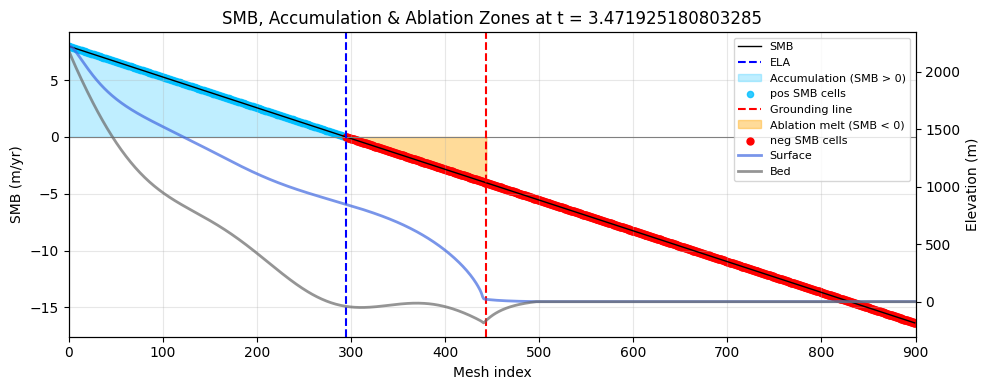

In [338]:
plot_ablation_zone_with_geometry(20)

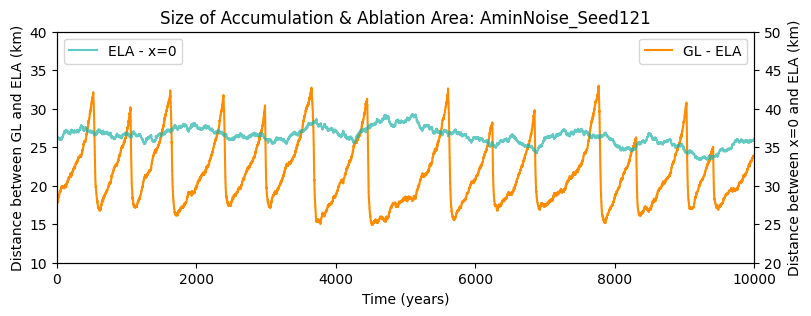

In [ ]:
# Plotting Accumulation & Ablation Area Distance
ELA = []
ELA_base = []

for t in SMB_dict:
    smb = np.asarray(SMB_dict[t], dtype=float)
    idx = int(np.nanargmin(np.abs(smb)))
    ELA.append(idx)

for t in SMB_dictBase:
    smb_base = np.asarray(SMB_dictBase[t], dtype=float)
    idx_base = int(np.nanargmin(np.abs(smb_base)))
    ELA_base.append(idx_base)

ELA_km = mesh_index_to_km(np.array(ELA))
ELA_base_km = mesh_index_to_km(np.array(ELA_base))

abl_dist = GL_Noisy_km - ELA_km
acc_dist = ELA_km - 0
fig,ax = plt.subplots(figsize=(9,3))

ax.plot(timesteps_noise, abl_dist, color ='darkorange', label = "GL - ELA")
ax.set_xlim(0,10000)
ax.set_ylim(10, 40)
ax.set_ylabel("Distance between GL and ELA (km)")
ax.set_xlabel("Time (years)")
ax.set_title(f"Size of Accumulation & Ablation Area: {runName}")
ax.legend()

ax2 = ax.twinx()
ax2.plot(timesteps_noise, acc_dist, color = 'lightseagreen', label = "ELA - x=0", alpha = 0.7)
ax2.set_ylabel("Distance between x=0 and ELA (km)")
ax2.set_ylim(20, 50)
ax2.legend(loc = 2)


# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_ACC_ABL_Area.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_ACC_ABL_Area.png", format ="png", bbox_inches='tight')

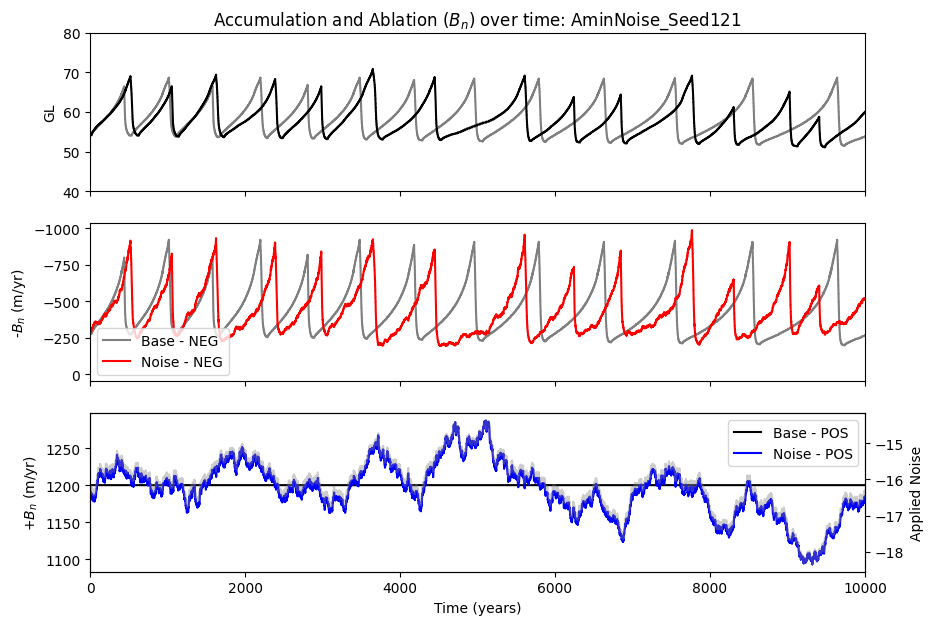

In [ ]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize =(10,7))

ax[0].plot(timesteps_noise, GL_Noisy_km, color='black')
ax[0].plot(timesteps_Base, GL_kmBase, color='black', alpha=0.5, label= 'GL (Base Run)')

# ax2 = ax[0].twinx()
# ax2.plot(timesteps_csv,noisy_amax_series)

ax[0].set_xlim(0,10000)
ax[0].set_ylim(40,80)
ax[0].set_ylabel('GL')

ax[1].plot(timesteps_Base, NEG_B_n_base.values(), color = 'black', label = 'Base - NEG', alpha = 0.5 )
ax[1].plot(timesteps_noise, NEG_B_n.values(), color = 'red', label = 'Noise - NEG')
ax[1].set_ylabel("-$B_n$ (m/yr)")
ax[1].set_xlim(0,10000)
ax[1].invert_yaxis()
ax[1].legend()

ax[2].plot(timesteps_Base, POS_B_n_base.values(), color = 'black', label = 'Base - POS')
ax[2].plot(timesteps_noise, POS_B_n.values(), color = 'blue', label = 'Noise - POS')

ax2 = ax[2].twinx()
ax2.plot(timesteps_csv, noisy_amin_series, color = 'grey', alpha = 0.4)
ax2.set_ylabel('Applied Noise')
ax[2].set_xlabel("Time (years)")
ax[2].set_ylabel("+$B_n$ (m/yr)")
ax[2].set_xlim(0,10000)
ax[2].legend()


ax[0].set_title(f"Accumulation and Ablation ($B_n$) over time: {runName}")

# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_Bn.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_Bn.png", format ="png", bbox_inches='tight')

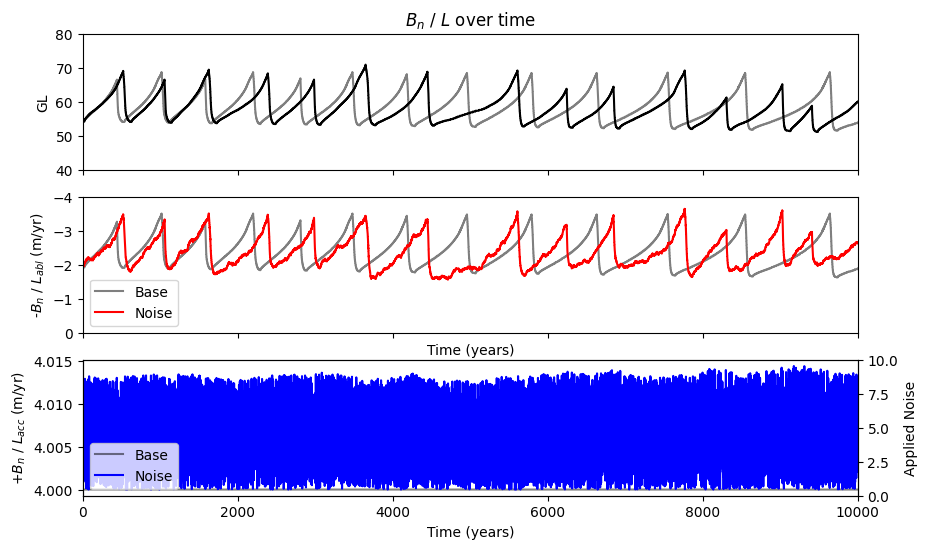

In [ ]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize =(10,6))

ax[0].plot(timesteps_Base, GL_kmBase, color='black', alpha=0.5, label= 'GL (Base Run)')
ax[0].plot(timesteps_noise, GL_Noisy_km, color='black')
ax[0].set_xlim(0,10000)
ax[0].set_ylim(40,80)
ax[0].set_ylabel('GL')

ax[1].plot(timesteps_Base, NEG_B_n_avg_base.values(), color = 'black', label = 'Base', alpha = 0.5 )
ax[1].plot(timesteps_noise, NEG_B_n_avg.values(), color = 'red', label = 'Noise')
ax[1].set_xlabel("Time (years)")
ax[1].set_ylabel("-$B_n$ / $L_{abl}$ (m/yr)")
ax[1].set_xlim(0,10000)
ax[1].invert_yaxis()
ax[1].legend()
ax[1].set_ylim(0,-4)

ax[2].plot(timesteps_Base, POS_B_n_avg_base.values(), color = 'black', label = 'Base', alpha = 0.5)
ax[2].plot(timesteps_noise, POS_B_n_avg.values(), color = 'blue', label = 'Noise')

ax2 = ax[2].twinx()
ax2.plot(timesteps_csv, noisy_amin_series, color = 'pink', alpha = 0.8)
ax2.set_ylabel('Applied Noise')
ax[2].set_xlabel("Time (years)")
ax[2].set_ylabel("+$B_n$ / $L_{acc}$ (m/yr)")
ax[2].set_xlim(0,10000)
ax[2].legend(loc=3)
ax2.set_ylim(0,10)

ax[0].set_title("$B_n$ / $L$ over time")

# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_Bn_L.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_Bn_L.png", format ="png", bbox_inches='tight')

In [342]:
# for item, amount in NEG_B_n_avg.items():
#     print(f"{item}: {amount}")

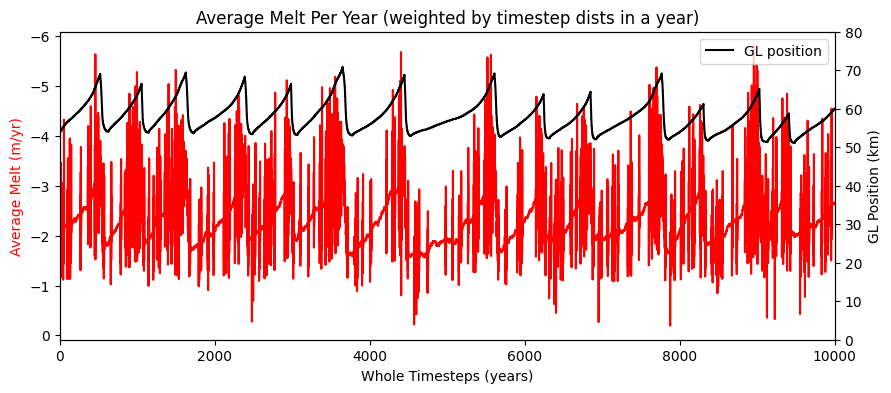

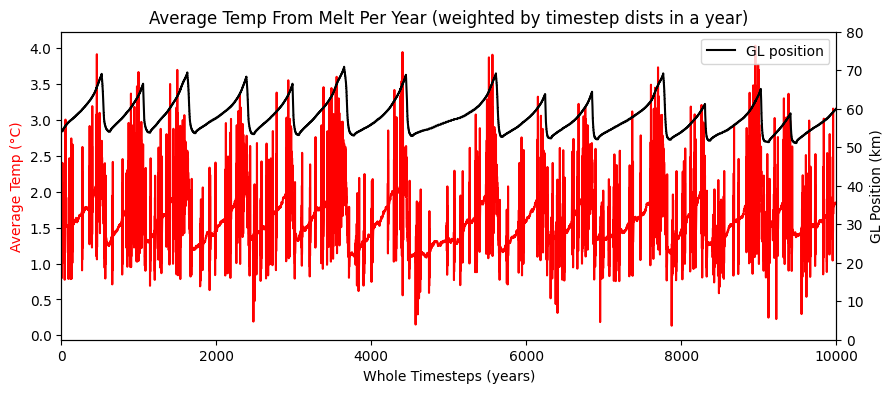

In [ ]:
# new version considering distance between timesteps
melt_sums_year = defaultdict(float)
count_steps = defaultdict(int)

DDF_ice = 0.008    # Melt factor in m w.e./°C/day
DD_idx = {}     # Degree Day Index
mean_temp = {}

days_melt = 180   # Number of melt days in a year

dt_year = {}

for i,t in enumerate(timestepsSMB):
   if i < len(timestepsSMB)-1:
        dt_year[t] = float(timestepsSMB[i+1]-t)
   else:
        dt_year[t] = float(timestepsSMB[i]-timestepsSMB[i-1]) if i>0 else 0.0


for t, rate in sorted(NEG_B_n_avg.items()):
   year = int(math.floor(t))  # bin by whole year
   dt_yr = max(dt_year.get(t, 0.0), 0.0)

   d_mwe = rate * dt_yr  # mwe for this timestep
   
   melt_sums_year[year] += d_mwe

   count_steps[year] += 1 

# for item, amount in melt_sums_year.items():
#     print(f"{item}: {amount}")

# Plotting Average Melt per Year
fig,ax = plt.subplots(figsize = (10,4))


ax.plot(melt_sums_year.keys(), melt_sums_year.values(), '-', color = 'red')
ax.set_title("Average Melt Per Year (weighted by timestep dists in a year)")
ax.set_ylabel("Average Melt (m/yr)", color = 'red')
ax.set_xlabel("Whole Timesteps (years)")
ax.set_xlim(0,10000)

ax.invert_yaxis()


ax2 = ax.twinx()
ax2.plot(timesteps_noise, GL_Noisy_km, color = 'black', label = "GL position")
ax2.set_ylim(0,80)
ax2.set_ylabel("GL Position (km)")
ax2.legend()

# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_AVG_melt_weighted.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_AVG_melt_weighted.png", format ="png", bbox_inches='tight')

# Calculating DD Index and Associated Temperature 
for y in melt_sums_year:
    DD_idx[y] = abs(melt_sums_year[y])/ DDF_ice

for y in DD_idx:
    mean_temp[y] = DD_idx[y] / days_melt                  
     

# Plotting Temperature 
fig,ax = plt.subplots(figsize = (10,4))


ax.plot(mean_temp.keys(), mean_temp.values(), '-', color = 'red')
ax.set_title("Average Temp From Melt Per Year (weighted by timestep dists in a year)")
ax.set_ylabel("Average Temp (°C)", color = 'red')
ax.set_xlabel("Whole Timesteps (years)")
ax.set_xlim(0,10000)


ax2 = ax.twinx()
ax2.plot(timesteps_noise, GL_Noisy_km, color = 'black', label = "GL position")
ax2.set_ylim(0,80)
ax2.set_ylabel("GL Position (km)")
ax2.legend()


# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_AVG_temp_weighted.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_AVG_temp_weighted.png", format ="png", bbox_inches='tight')

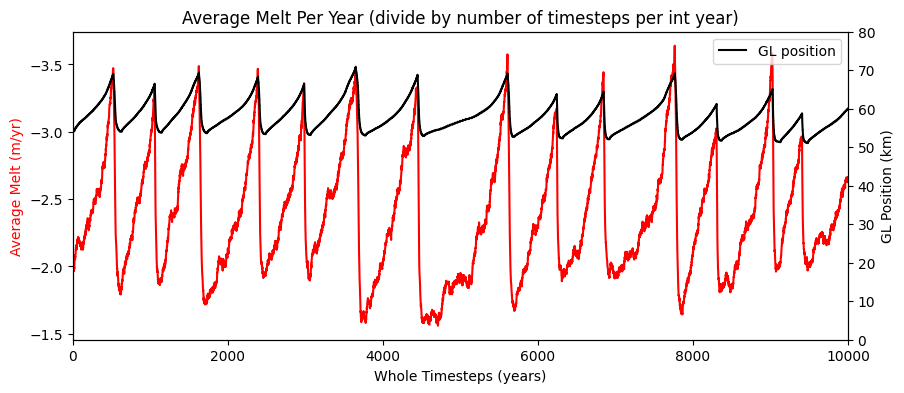

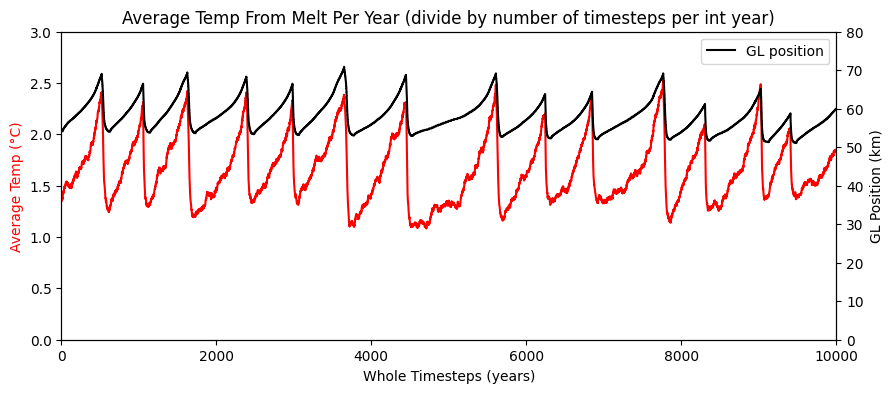

In [ ]:
# original version that just divides by the number of steps within a whole year
melt_sums_year = defaultdict(float)
count_steps = defaultdict(int)

DDF_ice = 0.008    # Melt factor in m w.e./°C/day
DD_idx = {}     # Degree Day Index
mean_temp = {}

days_melt = 180   # Number of melt days in a year

for t, val in NEG_B_n_avg.items():
   year = math.floor(t)  # bin by whole year
   melt_sums_year[year] += val
   count_steps[year] += 1 


melt_year_avg = {year: melt_sums_year[year] / count_steps[year] for year in melt_sums_year}


# for item, amount in melt_year_avg.items():
#     print(f"{item}: {amount}")

fig,ax = plt.subplots(figsize = (10,4))


ax.plot(melt_year_avg.keys(), melt_year_avg.values(), '-', color = 'red')
ax.set_title("Average Melt Per Year (divide by number of timesteps per int year)")
ax.set_ylabel("Average Melt (m/yr)", color = 'red')
ax.set_xlabel("Whole Timesteps (years)")
ax.set_xlim(0,10000)

ax.invert_yaxis()


ax2 = ax.twinx()
ax2.plot(timesteps_noise, GL_Noisy_km, color = 'black', label = "GL position")
ax2.set_ylim(0,80)
ax2.set_ylabel("GL Position (km)")
ax2.legend()

# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_AVG_melt_numsteps.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_AVG_melt_numsteps.png", format ="png", bbox_inches='tight')


# Calculating DD Index and Associated Temperature 
for y in melt_year_avg:
   DD_idx[y] = np.abs(melt_year_avg[y]) / DDF_ice     # in °C

for y in DD_idx:
   mean_temp[y] = DD_idx[y] / days_melt                


# for item, amount in DD_idx.items():
#     print(f"* {item}: {amount}")

# for item, amount in mean_temp.items():
#     print(f"* {item}: {amount}")

# Plotting Temperature 
fig,ax = plt.subplots(figsize = (10,4))


ax.plot(mean_temp.keys(), mean_temp.values(), '-', color = 'red')
ax.set_title("Average Temp From Melt Per Year (divide by number of timesteps per int year)")
ax.set_ylabel("Average Temp (°C)", color = 'red')
ax.set_xlabel("Whole Timesteps (years)")
ax.set_xlim(0,10000)
ax.set_ylim(0,3)


ax2 = ax.twinx()
ax2.plot(timesteps_noise, GL_Noisy_km, color = 'black', label = "GL position")
ax2.set_ylim(0,80)
ax2.set_ylabel("GL Position (km)")
ax2.legend()

# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_AVG_temp_numsteps.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/{runName}_AVG_temp_numsteps.png", format ="png", bbox_inches='tight')

# Velocity

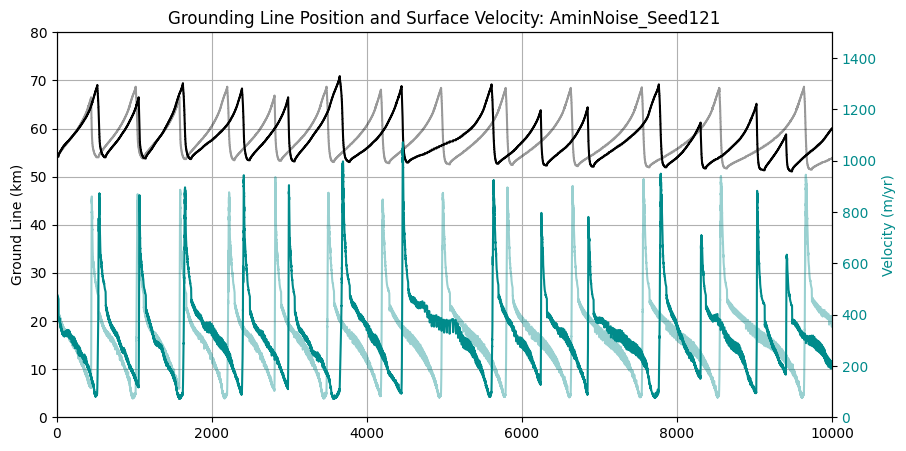

In [ ]:
fig,ax = plt.subplots(nrows = 1, sharex = True, figsize = (10,5))

# GL position
ax.plot(timesteps_noise, GL_Noisy_km, label='Grounding Line Position', color='black')
ax.plot(timesteps_Base, GL_kmBase, label='Grounding Line Position', color='black', alpha = 0.4)
ax.set_ylabel("Ground Line (km)", color='black')
ax.tick_params(axis='y', labelcolor='black')
ax.grid()

# Velocity
ax2 = ax.twinx()
ax2.plot(timesteps_noise, term_us, 'darkcyan', ls = '-', label='Surface Velocity (km/yr)')
ax2.plot(timesteps_Base, term_us_base, 'darkcyan', ls = '-', alpha = 0.4)
ax2.set_ylabel("Velocity (m/yr)", color='darkcyan')
ax2.tick_params(axis='y', labelcolor='darkcyan')

ax.set_xlim(0,10000)
ax.set_ylim(0,80)
ax2.set_ylim(0,1500)

ax.set_title(f"Grounding Line Position and Surface Velocity: {runName}")

plt.show()
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/GL_SurfVel_{runName}.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/GL_SurfVel_{runName}.png", format ="png", bbox_inches='tight')


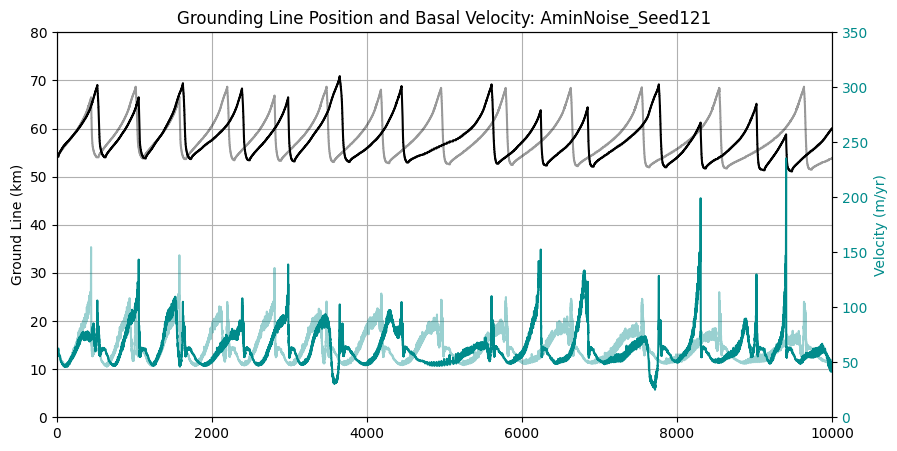

In [ ]:
fig,ax = plt.subplots(nrows = 1, sharex = True, figsize = (10,5))

# GL position
ax.plot(timesteps_noise, GL_Noisy_km, label='Grounding Line Position', color='black')
ax.plot(timesteps_Base, GL_kmBase, label='Grounding Line Position', color='black', alpha = 0.4)
ax.set_ylabel("Ground Line (km)", color='black')
ax.tick_params(axis='y', labelcolor='black')
ax.grid()

# Velocity
ax2 = ax.twinx()
ax2.plot(timesteps_noise, term_ub, 'darkcyan', ls = '-', label='Basal Velocity (km/yr)')
ax2.plot(timesteps_Base, term_ub_base, 'darkcyan', ls = '-', alpha = 0.4)
ax2.set_ylabel("Velocity (m/yr)", color='darkcyan')
ax2.tick_params(axis='y', labelcolor='darkcyan')

ax.set_xlim(0,10000)
ax.set_ylim(0,80)
ax2.set_ylim(0,350)

ax.set_title(f"Grounding Line Position and Basal Velocity: {runName}")

plt.show()
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/GL_BaseVel_{runName}.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/GL_BaseVel_{runName}.png", format ="png", bbox_inches='tight')


# Thickness

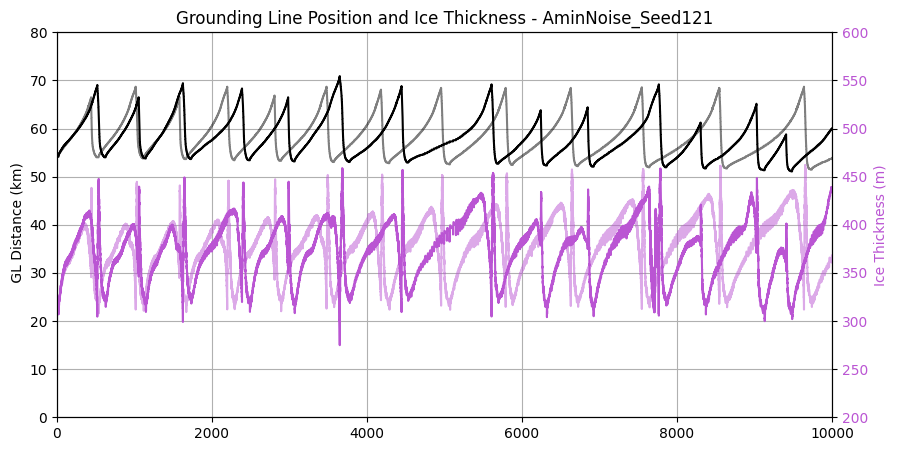

In [ ]:
fig,ax = plt.subplots(nrows = 1, sharex = True, figsize = (10,5))

# Noisy GL position
ax.plot(timesteps_Base, GL_kmBase, color='black', alpha = 0.5)
ax.plot(timesteps_noise, GL_Noisy_km, label='Grounding Line Position', color='black')
ax.set_ylabel(f" GL Distance (km)", color='black')
ax.tick_params(axis='y', labelcolor='black')
ax.set_xlim(0,2000)
ax.grid()

# Noisy Thickness
ax2 = ax.twinx()
ax2.plot(timesteps_Base, term_H_base, color='mediumorchid', linestyle='-', label=f'Ice Thickness', alpha = 0.5)
ax2.plot(timesteps_noise, term_H, color='mediumorchid', linestyle='-', label=f'Ice Thickness')
ax2.set_ylabel(("Ice Thickness (m)"), color='mediumorchid')
ax2.tick_params(axis='y', labelcolor='mediumorchid')

ax.set_xlim(0,10000)
ax.set_ylim(0,80)
ax2.set_ylim(200,600)

ax.set_title(f"Grounding Line Position and Ice Thickness - {runName}")
plt.show()

# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/GL_Thick_{runName}.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/GL_Thick_{runName}.png", format ="png", bbox_inches='tight')


# Sediment Flux

Text(0.5, 1.0, ' GL VS Mean Sed Discharge: AminNoise_Seed121')

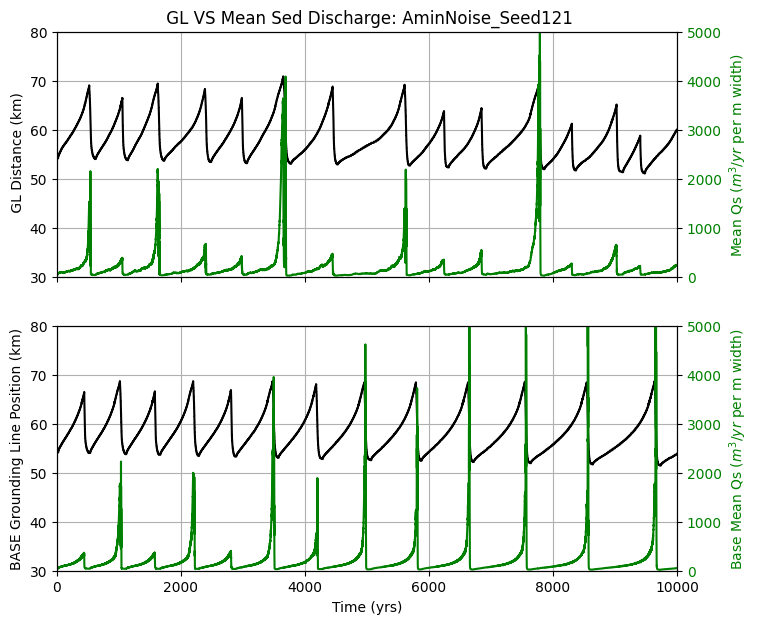

In [348]:
# Mean sediment discharge 
mean_Qs_filtered = np.array([
    np.mean([q for q in values if q > 1]) if any(q > 1 for q in values) else np.nan
    for values in Qs_dict.values()
])

# mean_Qs_base = np.array([np.mean(values) for values in Qs_dictBase.values()])
mean_Qs_filtered_base = np.array([
    np.mean([q for q in values if q > 1]) if any(q > 1 for q in values) else np.nan
    for values in Qs_dictBase.values()
])


fig,ax = plt.subplots(nrows = 2, sharex = True, figsize = (8,7))

# Noisy GL position
ax[0].plot(timesteps_noise, GL_Noisy_km, label='Grounding Line Position', color='black')
ax[0].set_ylabel(f" GL Distance (km)", color='black')
ax[0].tick_params(axis='y', labelcolor='black')
ax[0].grid()

# Noisy Sediment Discharge 
ax2 = ax[0].twinx()
ax2.plot(timesteps_noise, mean_Qs_filtered, 'green', ls = '-')
ax2.set_ylabel("Mean Qs ($m^3/yr$ per m width)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax[0].set_xlim(0,10000)
ax[0].set_ylim(30,80)
ax2.set_ylim(0,5000)

# Base GL position
ax[1].plot(timesteps_Base, GL_kmBase, color='black')
ax[1].set_xlabel("Time (yrs)")
ax[1].set_ylabel("BASE Grounding Line Position (km)", color='black')
ax[1].tick_params(axis='y', labelcolor='black')
ax[1].grid()
ax[1].set_ylim(30,80)

# Base Sediment Discharge
ax2 = ax[1].twinx()
ax2.plot(timesteps_Base, mean_Qs_filtered_base, 'green', ls = '-')
ax2.set_ylabel("Base Mean Qs ($m^3/yr$ per m width)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax[0].set_xlim(0,10000)
ax[0].set_ylim(30,80)
ax2.set_ylim(0,5000)

ax[0].set_title(f" GL VS Mean Sed Discharge: {runName}")

# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/GL_meanQs_{runName}.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/GL_meanQs_{runName}.png", format ="png", bbox_inches='tight')


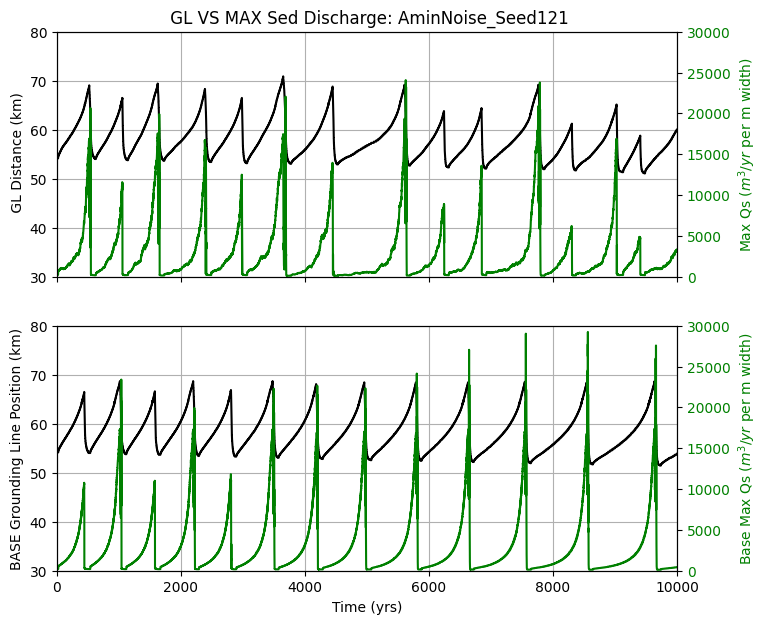

In [ ]:
# Maximum Sediment Discharge
fig,ax = plt.subplots(nrows = 2, sharex = True, figsize = (8,7))

# Noisy GL position
ax[0].plot(timesteps_noise, GL_Noisy_km, label='Grounding Line Position', color='black')
ax[0].set_ylabel(f" GL Distance (km)", color='black')
ax[0].tick_params(axis='y', labelcolor='black')
ax[0].grid()

# Noisy Sediment Discharge 
ax2 = ax[0].twinx()
ax2.plot(timesteps_noise, max_Qs, 'green', ls = '-')
ax2.set_ylabel("Max Qs ($m^3/yr$ per m width)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax[0].set_xlim(0,10000)
ax[0].set_ylim(30,80)
ax2.set_ylim(0,30000)

# Base GL position
ax[1].plot(timesteps_Base, GL_kmBase, color='black')
ax[1].set_xlabel("Time (yrs)")
ax[1].set_ylabel("BASE Grounding Line Position (km)", color='black')
ax[1].tick_params(axis='y', labelcolor='black')
ax[1].grid()
ax[1].set_ylim(30,80)

# Base Sediment Discharge
ax2 = ax[1].twinx()
ax2.plot(timesteps_Base, max_Qs_base, 'green', ls = '-')
ax2.set_ylabel("Base Max Qs ($m^3/yr$ per m width)", color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax[0].set_xlim(0,10000)
ax[0].set_ylim(30,80)
ax2.set_ylim(0,30000)

ax[0].set_title(f" GL VS MAX Sed Discharge: {runName}")

# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/GL_QsMax_{runName}.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/GL_QsMax_{runName}.png", format ="png", bbox_inches='tight')


# Bedrock Change

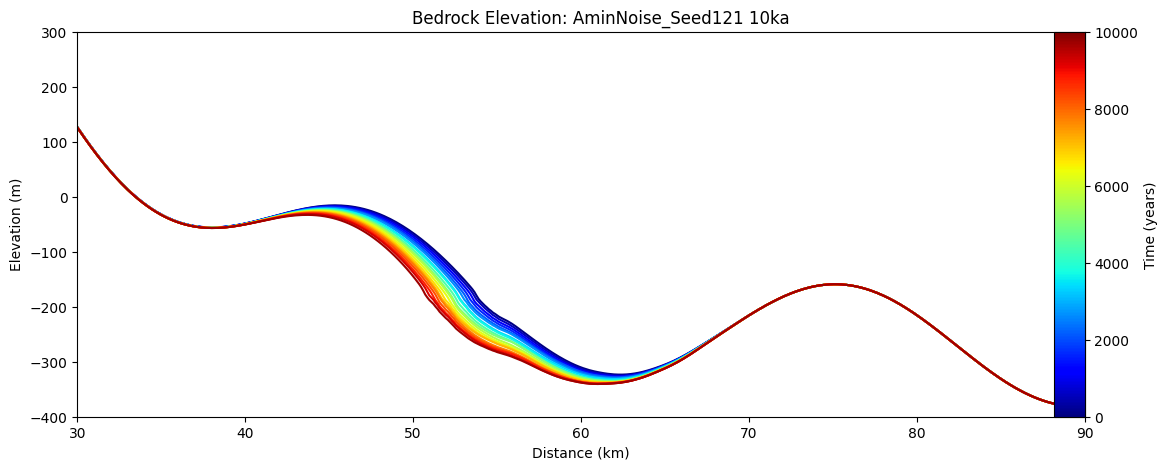

In [ ]:
num_points = len(next(iter(bed_dict.values())))
x_km = mesh_index_to_km(np.arange(num_points))
timesteps_noise = list(bed_dict.keys())
norm = plt.Normalize(min(timesteps_noise), max(timesteps_noise))
cmap = cm.jet

fig, ax1 = plt.subplots(figsize=(13,5))

for i, t in enumerate(timesteps_noise):
    if i % 1000 != 0:  
        continue
    bed = bed_dict[t]
    color = cmap(norm(t))
    ax1.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

ax1.set_xlabel("Distance (km)")
ax1.set_ylabel("Elevation (m)")
ax1.set_xlim(30, 90)
ax1.set_ylim(-400, 300)

# Make ScalarMappable for colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbaxes = inset_axes(ax1, width="3%", height="100%", loc='upper right',
                    bbox_to_anchor=(0, 0, 1, 1),
                    bbox_transform=ax1.transAxes, borderpad=0.01)

cbar = plt.colorbar(sm, cax=cbaxes)
cbar.set_label('Time (years)')
plt.title(f"Bedrock Elevation: {runName} {runTime}", position=(-15, 1.05))
plt.show()

# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/BedErosion_{runName}.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/BedErosion_{runName}.png", format ="png", bbox_inches='tight')



# Hovmoller Plots

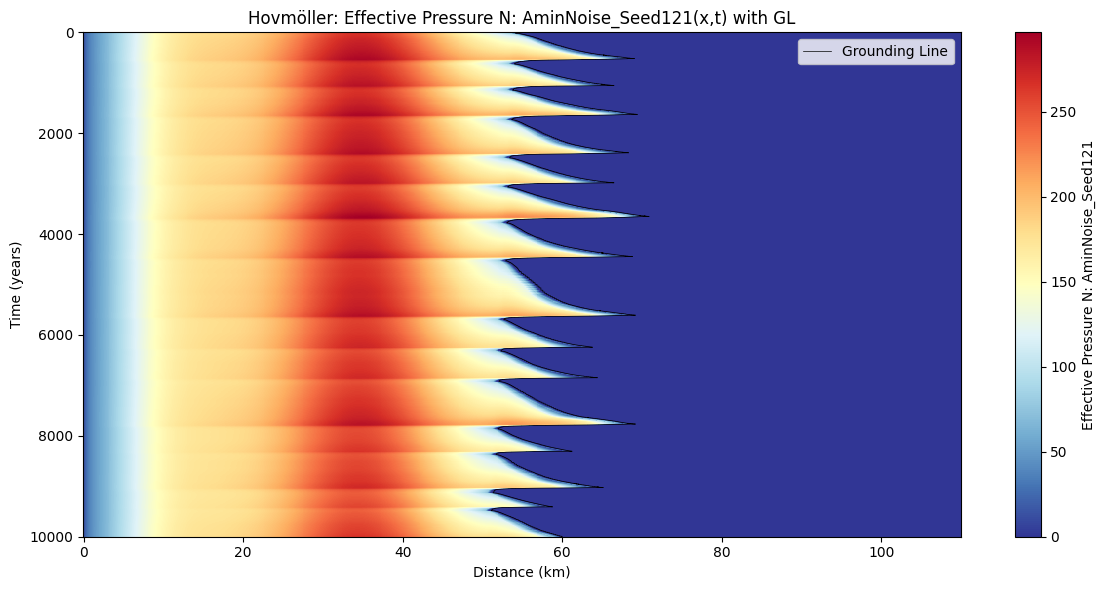

In [ ]:
# ===== Effective Pressure N =====
fig, ax, N_mat = make_hovmoller(N_dict, timesteps_noise, x_km, gl_positions, f'Effective Pressure N: {runName}', cmap='RdYlBu_r')
plt.show()
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/N_{runName}.png", format ="png", bbox_inches='tight')

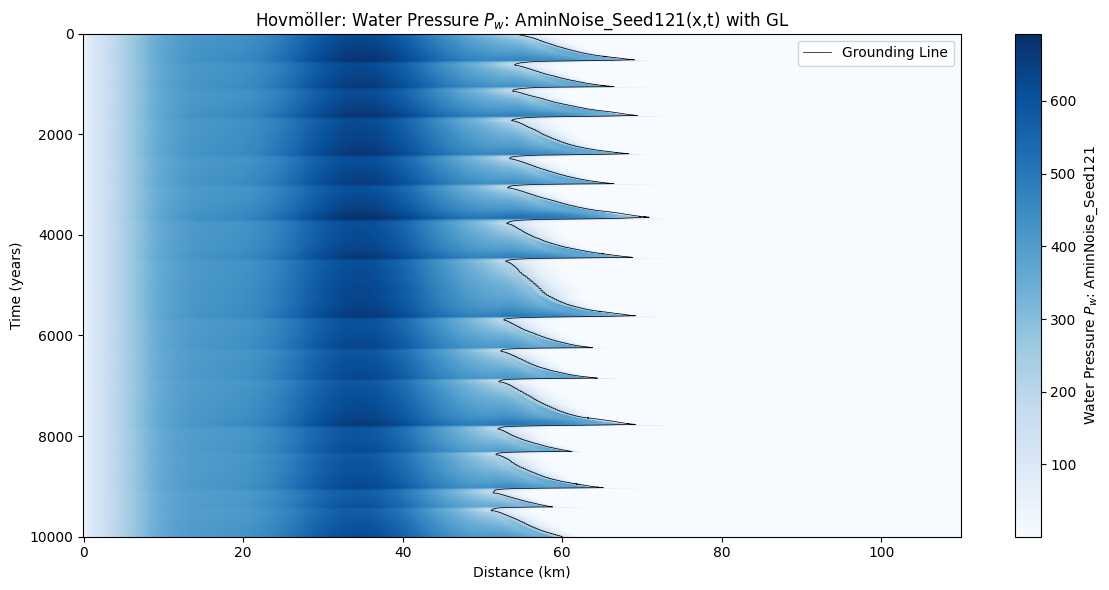

In [ ]:
# ===== Water Pressure Pw =====
fig, ax, Pw_mat = make_hovmoller(Pw_dict, timesteps_noise, x_km, gl_positions, f'Water Pressure $P_w$: {runName}', cmap='Blues')
plt.show()

# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/Pw_{runName}.png", format ="png", bbox_inches='tight')

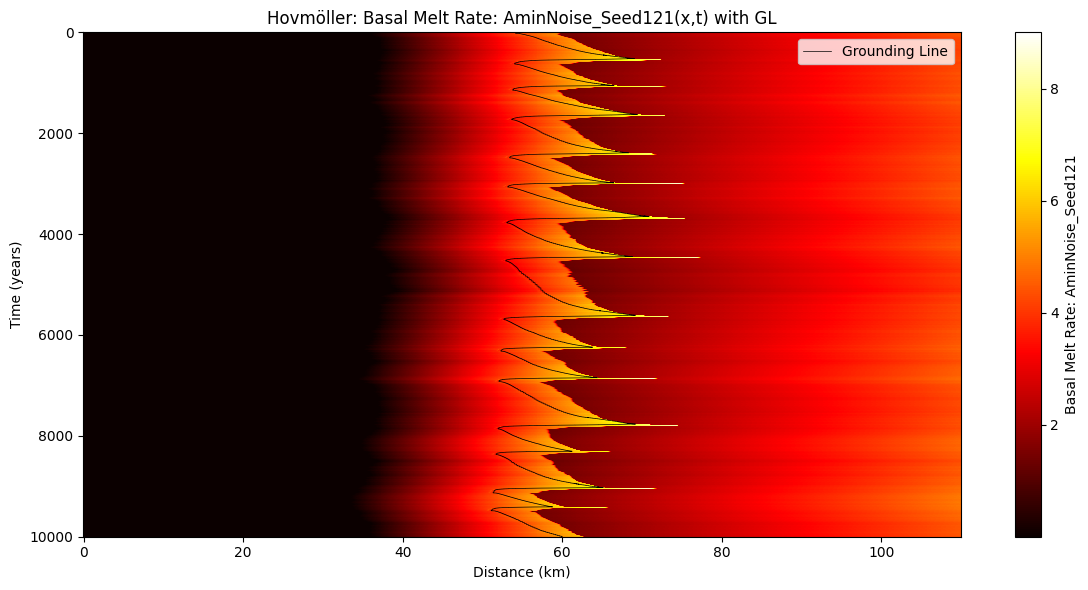

In [ ]:
# ===== Basal Melt me =====
fig, ax, me_mat = make_hovmoller(me_dict, timesteps_noise, x_km, gl_positions, f'Basal Melt Rate: {runName}', cmap='hot')
plt.show()
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/Me_{runName}.png", format ="png", bbox_inches='tight')

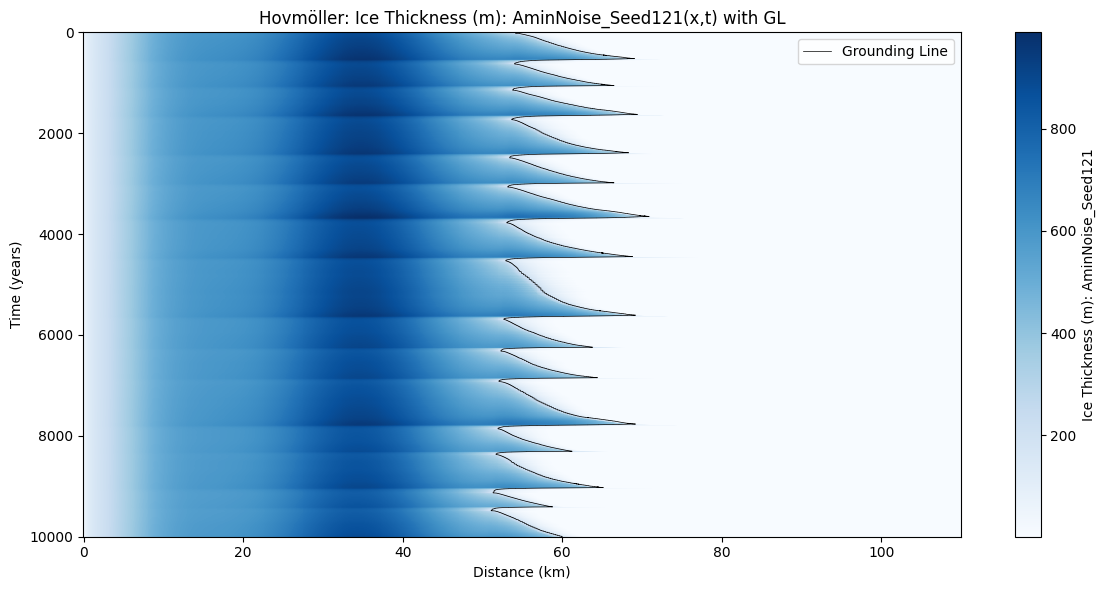

In [ ]:
# ===== Ice Thickness H =====
fig, ax, H_mat = make_hovmoller(H_dict, timesteps_noise, x_km, gl_positions, f'Ice Thickness (m): {runName}', cmap='Blues')
plt.show()
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/H_{runName}.png", format ="png", bbox_inches='tight')

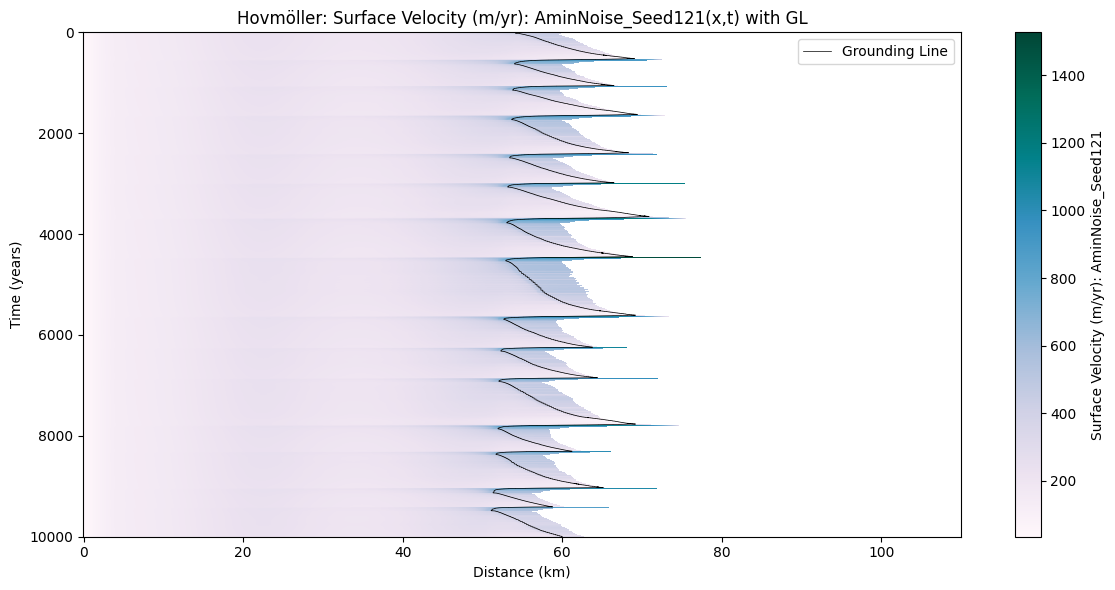

In [ ]:
# ===== Surface Velocity  =====
fig, ax, us_mat = make_hovmoller(us_dict, timesteps_noise, x_km, gl_positions, f'Surface Velocity (m/yr): {runName}', cmap='PuBuGn')
plt.show()
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/Us_{runName}.png", format ="png", bbox_inches='tight')

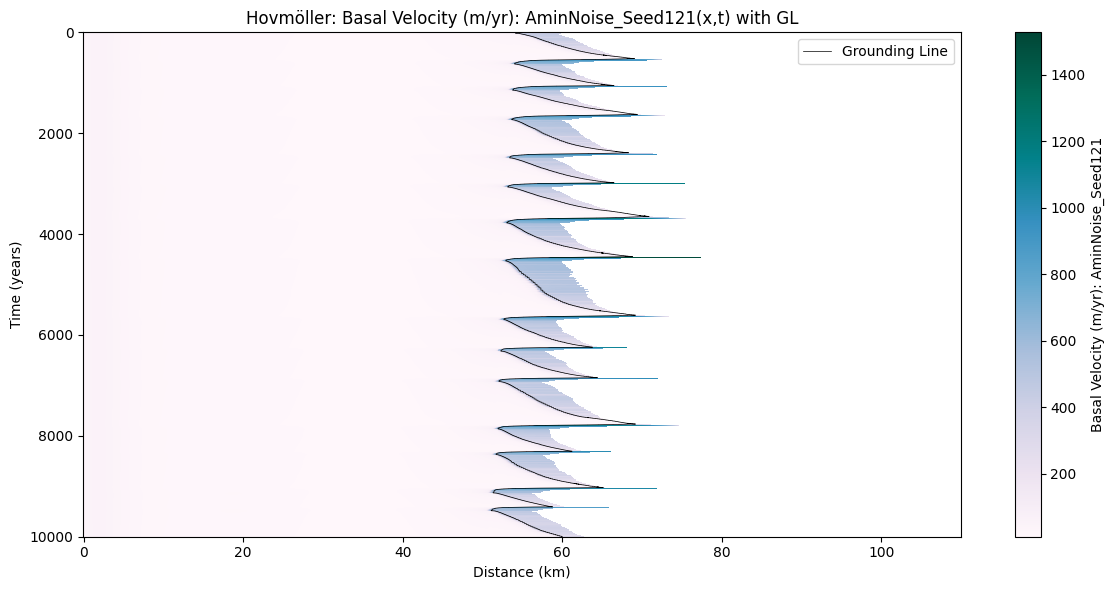

In [ ]:
# ===== Basal Velocity  =====
fig, ax, ub_mat = make_hovmoller(ub_dict, timesteps_noise, x_km, gl_positions, f'Basal Velocity (m/yr): {runName}', cmap='PuBuGn')
plt.show()
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/Ub_{runName}.png", format ="png", bbox_inches='tight')

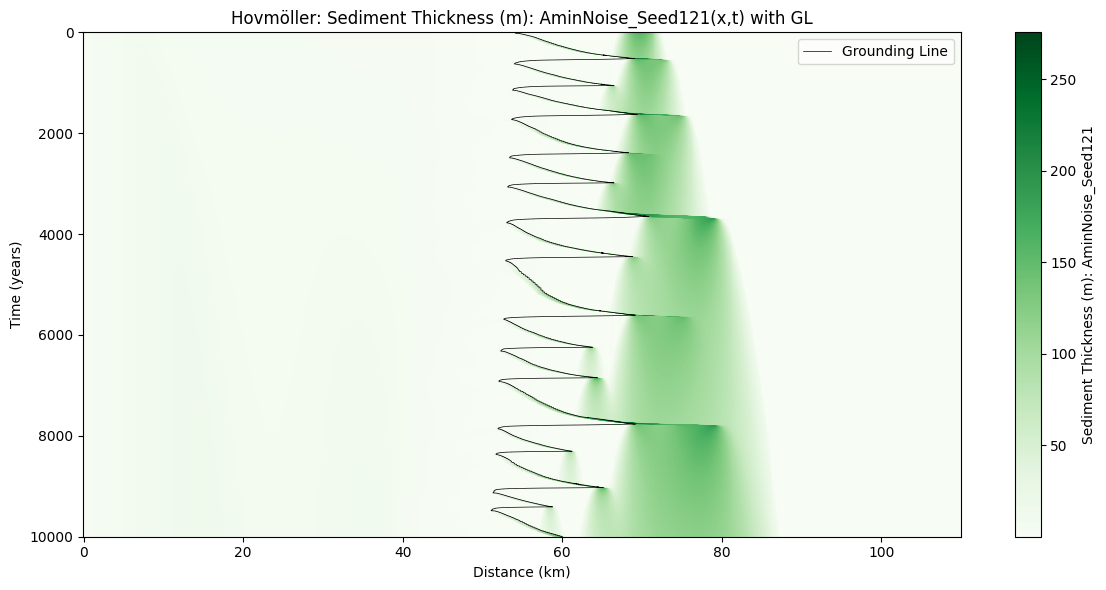

In [ ]:
# ===== Sediment Thickness  =====
fig, ax, Hs_mat = make_hovmoller(Hs_dict, timesteps_noise, x_km, gl_positions, f'Sediment Thickness (m): {runName}', cmap='Greens')
plt.show()
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/Hs_{runName}.png", format ="png", bbox_inches='tight')

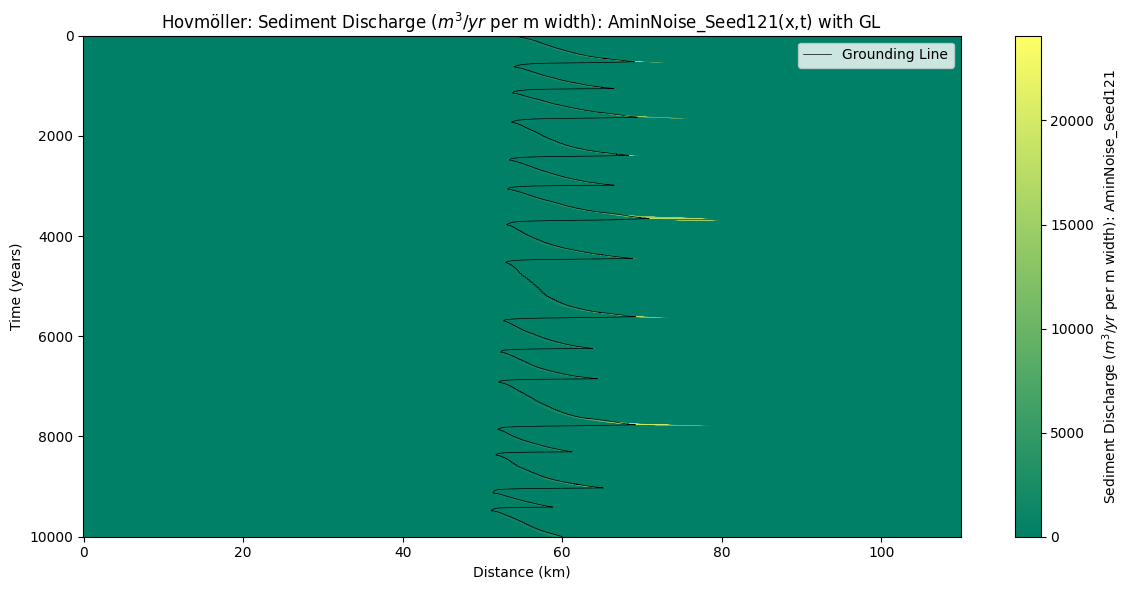

In [ ]:
# ===== Sediment Discharge  =====
fig, ax, Qs_mat = make_hovmoller(Qs_dict, timesteps_noise, x_km, gl_positions, f'Sediment Discharge ($m^3/yr$ per m width): {runName}', cmap='summer')
plt.show()
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/Qs_{runName}.png", format ="png", bbox_inches='tight')

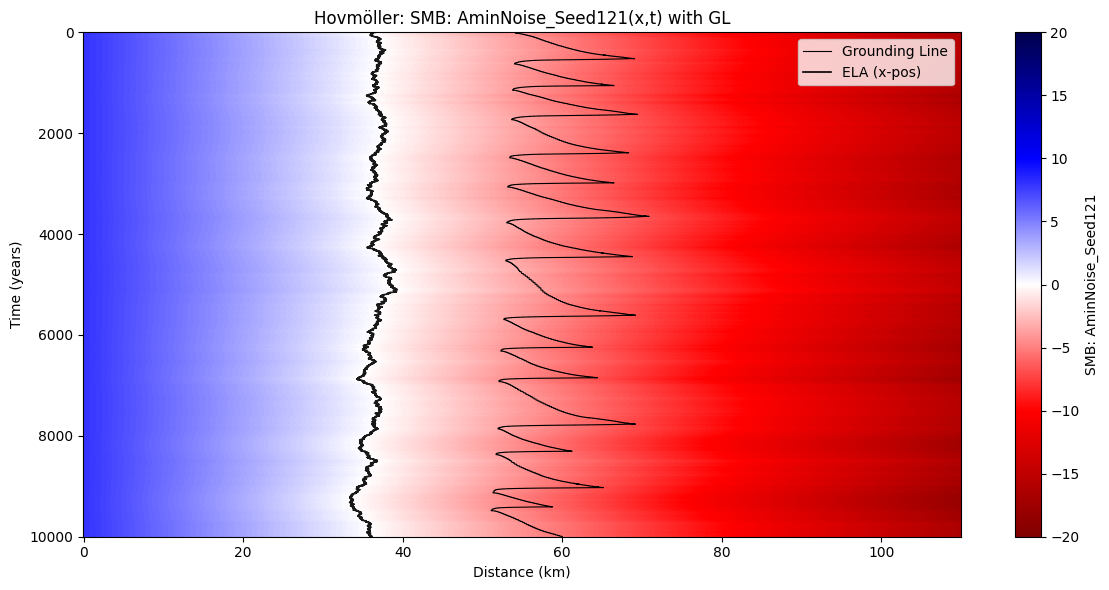

In [ ]:
# ===== SMB  =====
fig, ax, SMB_mat = make_hovmoller_SMB(SMB_dict, timesteps_noise, x_km, gl_positions, f'SMB: {runName}', cmap='seismic_r', vmin= -20, vmax=20, center_zero=True, draw_zero_line=True)
plt.show()
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/SMB_{runName}.png", format ="png", bbox_inches='tight')

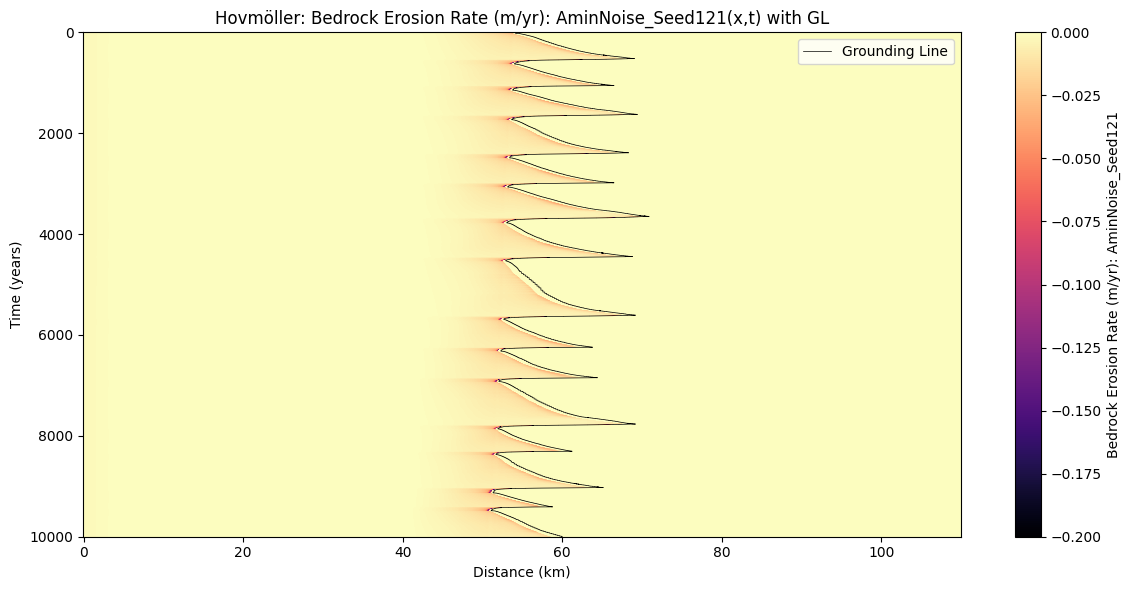

In [ ]:
# ===== Bedrock Erosion =====
fig, ax, Bdot_mat = make_hovmoller(Bdot_dict, timesteps_noise, x_km,gl_positions, f'Bedrock Erosion Rate (m/yr): {runName}', cmap='magma', vmin=-0.2)
plt.show()
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/Bdot_{runName}.png", format ="png", bbox_inches='tight')

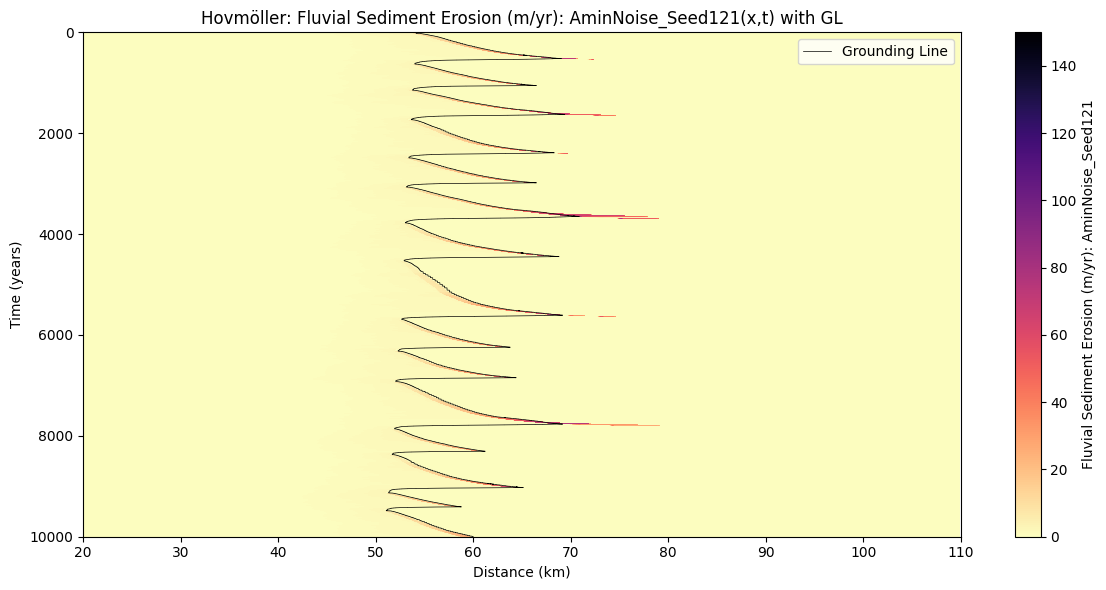

In [ ]:
# ===== Fluvial Sediment Erosion =====
fig, ax, Edot_mat = make_hovmoller(edot_dict, timesteps_noise, x_km,gl_positions, f'Fluvial Sediment Erosion (m/yr): {runName}', cmap='magma_r', vmax=150)
plt.xlim(20,110)
plt.show()
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/Edot_{runName}.png", format ="png", bbox_inches='tight')

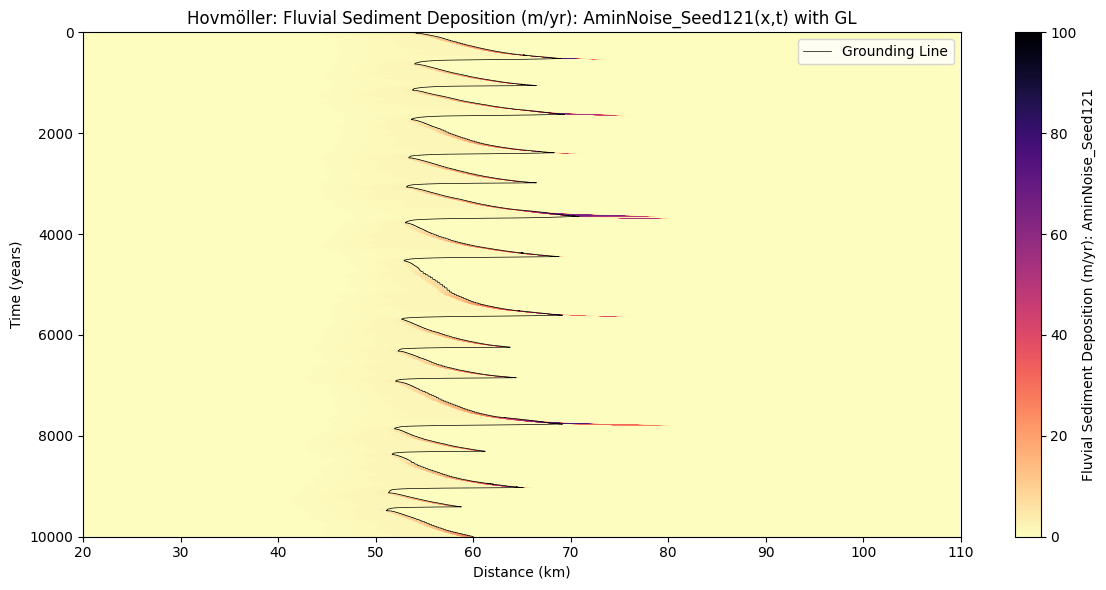

In [ ]:
# ===== Fluvial Sediment Deposition =====
fig, ax, Ddot_mat = make_hovmoller(ddot_dict, timesteps_noise, x_km,gl_positions, f'Fluvial Sediment Deposition (m/yr): {runName}', cmap='magma_r', vmax = 100)
plt.xlim(20,110)
plt.show()
# fig.savefig(f"/media/kayatroyer/KayaDrive/TWG_Paper/ClimateChangeExperiments/MostImportantTests/NoiseTests_HighRes/tempfigs/Take2/Seed121/Amin/Ddot_{runName}.png", format ="png", bbox_inches='tight')

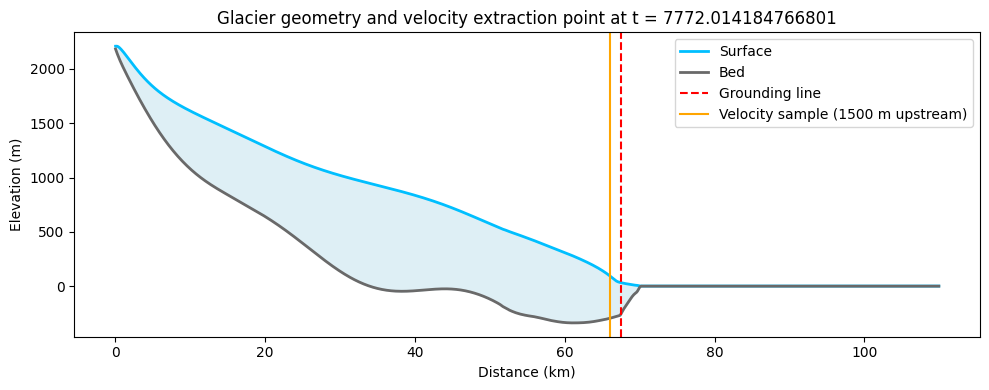

In [363]:
t_plot = sorted(us_dict.keys())[14000]

surf = surf_dict[t_plot]
base = base_dict[t_plot]
gl_array = GL_dict[t_plot]
us = us_dict[t_plot]

domain_length_m = 110e3
ncells = 900
dx = domain_length_m / ncells
x_cells = np.linspace(dx/2, domain_length_m - dx/2, ncells)
offset_cells = int(round(offset_m / dx))

gl_index = get_GL_index(gl_array)
target_index = max(gl_index - offset_cells, 0)

# --- Plot glacier geometry ---
plt.figure(figsize=(10, 4))
plt.plot(x_cells / 1000, surf, label='Surface', color='deepskyblue', linewidth=2)
plt.plot(x_cells / 1000, base, label='Bed', color='dimgray', linewidth=2)

# Grounding line position
plt.axvline(x_cells[gl_index] / 1000, color='r', linestyle='--', label='Grounding line')

# Velocity extraction position 
plt.axvline(x_cells[target_index] / 1000, color='orange', linestyle='-', label=f'Velocity sample ({offset_m} m upstream)')

plt.fill_between(x_cells / 1000, base, surf, color='lightblue', alpha=0.4)
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.title(f'Glacier geometry and velocity extraction point at t = {t_plot}')
plt.legend()
plt.tight_layout()
plt.show()


# Stats for Current Run - Range, Mean, Standard Deviation

In [364]:
print("*"*60)
print(f"STATS FOR TEST: {runName} {runTime}")
print("*"*60)

print("\n" + "="*60)
print("AMIN STATS")
print("="*60)

print(f"Amin (MAX) = {min(noisy_amin_series)}")
print(f"Amin (MIN) = {max(noisy_amin_series)}")
print("")
print(f"Amin (MEAN) = {np.mean(noisy_amin_series)}")
print(f"Amin (STDEV) = {np.std(noisy_amin_series)}")

print("\n" + "="*60)
print("AMAX STATS")
print("="*60)

print(f"Amax (MAX) = {max(noisy_amax_series)}")
print(f"Amax (MIN) = {min(noisy_amax_series)}")
print("")
print(f"Amax (MEAN) = {np.mean(noisy_amax_series)}")
print(f"Amax (STDEV) = {np.std(noisy_amax_series)}")

************************************************************
STATS FOR TEST: AminNoise_Seed121 10ka
************************************************************

AMIN STATS
Amin (MAX) = -18.354206
Amin (MIN) = -14.369511

Amin (MEAN) = -16.134766597019407
Amin (STDEV) = 0.7410983229979895

AMAX STATS
Amax (MAX) = 8.0
Amax (MIN) = 8.0

Amax (MEAN) = 8.0
Amax (STDEV) = 0.0


# Stats for Current Run - Correlation of Direct Results and Anomalies

In [365]:
# Direct comparison of Amin/Amax to GL 
print("\n" + "="*60)
print("Direct comparison of Amax to GL ")
print("="*60)

# interpolating values onto timescales
gl_noisy_interp_yrs = np.interp(timesteps_csv, timesteps_noise, GL_Noisy_km)                   # GL interpolated onto yearly timesteps (Noise time)
gl_base_interp_yrs = np.interp(timesteps_csv, timesteps_Base, GL_kmBase)                             # BASE GL interpolated onto yearly timesteps (Noise time)


r = np.corrcoef(noisy_amax_series, gl_noisy_interp_yrs)[0,1]
print(f"Direct Correlation Between Amax Noise & GL Position (r):    {r:.4f}")
r2 = r**2
print(f"The GL Position explained by Amax Noise (r2):               {r2:.4f} or {(r2*100):.4f}%")
pearsons_corrcoef, p_corr = st.pearsonr(noisy_amax_series,gl_noisy_interp_yrs)
print(f"P-value of                                                  {(p_corr)}")

print("\n" + "="*60)
print("Direct comparison of Amin to GL ")
print("="*60)


r = np.corrcoef(noisy_amin_series, gl_noisy_interp_yrs)[0,1]
print(f"Direct Correlation Between Amin Noise & GL Position (r):    {r:.4f}")
r2 = r**2
print(f"The GL Position explained by Amin Noise (r2):               {r2:.4f} or {(r2*100):.4f}%")
pearsons_corrcoef, p_corr = st.pearsonr(noisy_amin_series,gl_noisy_interp_yrs)
print(f"P-value of                                                  {(p_corr)}")

print("*"*100)

# Comparison of Amin/Amax Noise Anomaly to GL Anomaly
GL_resid = gl_noisy_interp_yrs - gl_base_interp_yrs       # Residual of GL (Noisy - Base )

amax_noise_resid = noisy_amax_series - 8


print("\n" + "="*60)
print("Comparison of Amax Noise Anomaly to GL Anomaly")
print("="*60)
r = np.corrcoef(amax_noise_resid, GL_resid)[0,1]
print(f"Correlation Between Amax Noise Anomaly & GL Position Anomaly (r):    {r:.4f}")
r2 = r**2
print(f"The GL Position Anomaly explained by Amax Noise Anomaly (r2):        {r2:.4f} or {(r2*100):.4f}%")
pearsons_corrcoef, p_corr = st.pearsonr(amax_noise_resid,GL_resid)
print(f"P-value of                                                           {(p_corr)}")


amin_noise_resid = noisy_amin_series + 16 

print("\n" + "="*60)
print("Comparison of Amin Noise Anomaly to GL Anomaly")
print("="*60)
r = np.corrcoef(amin_noise_resid, GL_resid)[0,1]
print(f"Correlation Between Amin Noise Anomaly & GL Position Anomaly (r):   {r:.4f}")
r2 = r**2
print(f"The GL Position Anomaly explained by Amin Noise Anomaly (r2):       {r2:.4f} or {(r2*100):.4f}%")
pearsons_corrcoef, p_corr = st.pearsonr(amin_noise_resid,GL_resid)
print(f"P-value of                                                          {(p_corr)}")

print("\n"+"*"*100)



Direct comparison of Amax to GL 
Direct Correlation Between Amax Noise & GL Position (r):    nan
The GL Position explained by Amax Noise (r2):               nan or nan%
P-value of                                                  nan

Direct comparison of Amin to GL 
Direct Correlation Between Amin Noise & GL Position (r):    0.2132
The GL Position explained by Amin Noise (r2):               0.0455 or 4.5466%
P-value of                                                  3.7110806611881056e-103
****************************************************************************************************

Comparison of Amax Noise Anomaly to GL Anomaly
Correlation Between Amax Noise Anomaly & GL Position Anomaly (r):    nan
The GL Position Anomaly explained by Amax Noise Anomaly (r2):        nan or nan%
P-value of                                                           nan

Comparison of Amin Noise Anomaly to GL Anomaly
Correlation Between Amin Noise Anomaly & GL Position Anomaly (r):   0.0838
The 

/tmp/ipykernel_1690019/2571989003.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons_corrcoef, p_corr = st.pearsonr(noisy_amax_series,gl_noisy_interp_yrs)
/tmp/ipykernel_1690019/2571989003.py:45: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsons_corrcoef, p_corr = st.pearsonr(amax_noise_resid,GL_resid)


# Old Summary Plots

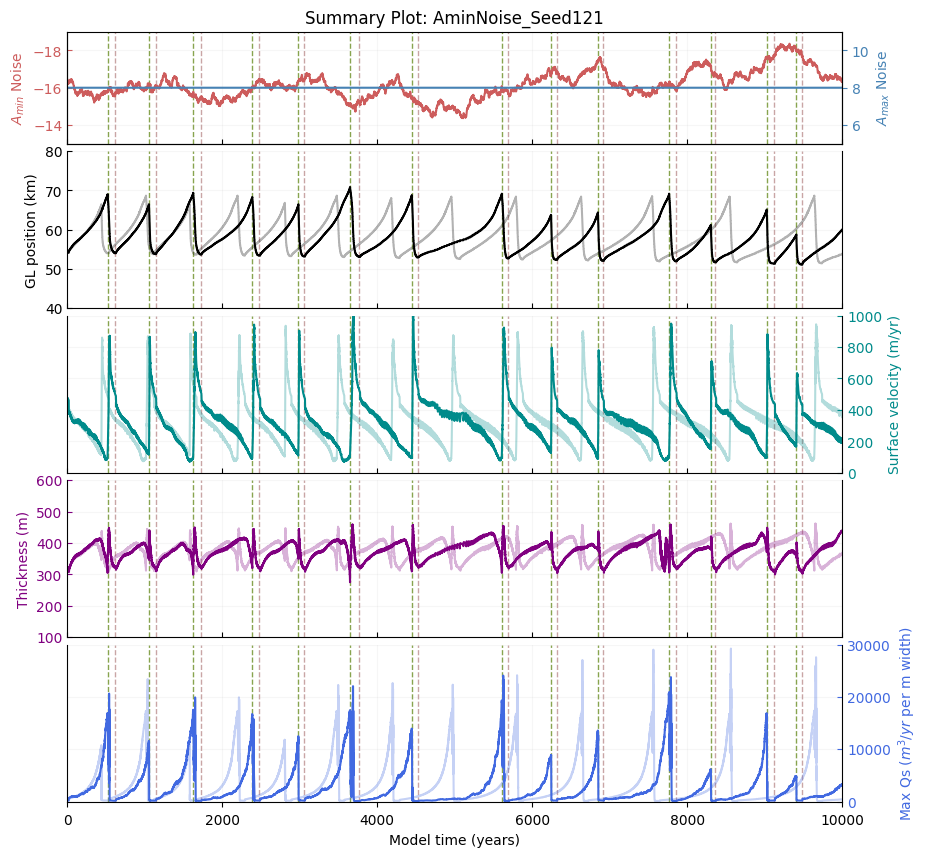

In [366]:
fig = plt.figure(figsize=(10,10))
gs = GridSpec(5, 1, height_ratios=[1, 1.4, 1.4, 1.4, 1.4], hspace=0.05)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax0)
ax3 = fig.add_subplot(gs[3], sharex=ax0)
ax4 = fig.add_subplot(gs[4], sharex=ax0)

# === Climate noise ===
ax0.plot(timesteps_csv, noisy_amin_series, color='indianred')
ax0.set_ylim(-13,-19)

ax0r = ax0.twinx()
ax0r.plot(timesteps_csv, noisy_amax_series, color='steelblue')
ax0r.set_ylim(5,11, auto = False)

ax0.set_ylabel('$A_{min}$ Noise', color='indianred')
ax0.tick_params(axis='y', colors='indianred')
ax0r.set_ylabel('$A_{max}$ Noise', color='steelblue')
ax0r.tick_params(axis='y', colors='steelblue')

# === GL plot ===
ax1.plot(timesteps_Base, GL_kmBase, color='black', alpha=0.3)
ax1.plot(timesteps_noise, GL_Noisy_km, color='black')
ax1.set_ylabel('GL position (km)', color='black')
ax1.set_ylim(40, 80)
ax1.tick_params(axis='y', colors='black')

# === Velocity plot ===
ax2.plot(timesteps_Base, term_us_base, color='darkcyan', alpha=0.3)
ax2.plot(timesteps_noise, term_us, color='darkcyan')
ax2.set_ylabel('Surface velocity (m/yr)', color='darkcyan')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.set_ylim(0,1000)
ax2.tick_params(axis='y', colors='darkcyan')

# === Thickness plot ===
ax3.plot(timesteps_Base, term_H_base, color='purple', alpha=0.3)
ax3.plot(timesteps_noise, term_H, color='purple')
ax3.set_ylabel('Thickness (m)', color='purple')
ax3.tick_params(axis='y', colors='purple')
ax3.set_ylim(100, 600)

# === Qs plot ===
ax4.plot(timesteps_Base, max_Qs_base, color='royalblue', alpha=0.3)
ax4.plot(timesteps_noise, max_Qs, color='royalblue')
ax4.set_ylabel('Max Qs ($m^3/yr$ per m width)', color='royalblue')
ax4.yaxis.set_label_position('right')
ax4.yaxis.tick_right()
ax4.set_ylim(0,30000)
ax4.tick_params(axis='y', colors='royalblue')

for a in [ax0, ax1, ax2, ax3, ax4]:
    a.spines['top'].set_visible(False)
    a.grid(alpha=0.1)
    a.set_xlim(0,10000)
    a.tick_params(direction='in')
    for t in peaktimes:
        a.axvline(x=t, color='olivedrab', lw=1, ls='--', alpha=0.8, zorder=0)
    for t in troughtimes:
        a.axvline(x=t, color='rosybrown', lw=1, ls='--', alpha=0.8, zorder=0)

for a in [ax0, ax1, ax2, ax3]:
    plt.setp(a.get_xticklabels(), visible=False)

ax0.set_title(f"Summary Plot: {runName}")
ax4.tick_params(axis='x', which='both', pad=5, direction='out')
ax4.set_xlabel('Model time (years)')

plt.show()

# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/SummaryPlots/{runName}_SummaryPlot_update_maxQs.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/SummaryPlots/{runName}_SummaryPlot_update_maxQs.png", format ="png", bbox_inches='tight')


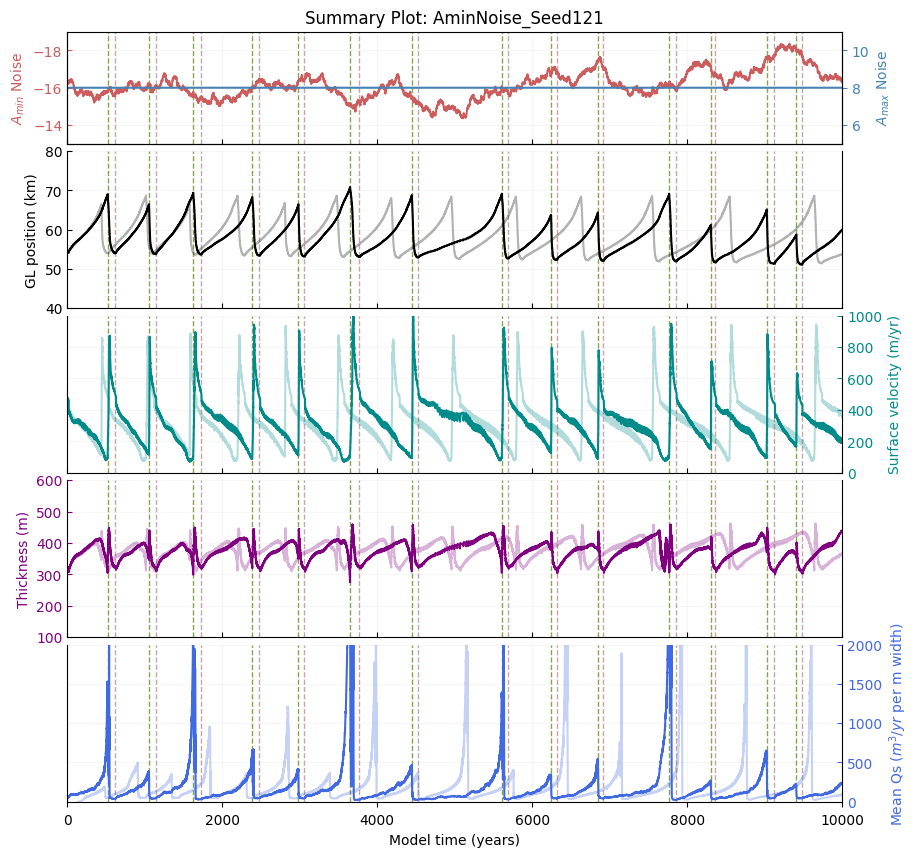

In [367]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(5, 1, height_ratios=[1, 1.4, 1.4, 1.4, 1.4], hspace=0.05)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax0)
ax3 = fig.add_subplot(gs[3], sharex=ax0)
ax4 = fig.add_subplot(gs[4], sharex=ax0)

# === Climate noise ===
ax0.plot(timesteps_csv, noisy_amin_series, color='indianred')
ax0.set_ylim(-13,-19)

ax0r = ax0.twinx()
ax0r.plot(timesteps_csv, noisy_amax_series, color='steelblue')
ax0r.set_ylim(5,11, auto = False)

ax0.set_ylabel('$A_{min}$ Noise', color='indianred')
ax0.tick_params(axis='y', colors='indianred')
ax0r.set_ylabel('$A_{max}$ Noise', color='steelblue')
ax0r.tick_params(axis='y', colors='steelblue')

# === GL plot ===
ax1.plot(timesteps_Base, GL_kmBase, color='black', alpha=0.3)
ax1.plot(timesteps_noise, GL_Noisy_km, color='black')
ax1.set_ylabel('GL position (km)', color='black')
ax1.set_ylim(40, 80)
ax1.tick_params(axis='y', colors='black')

# === Velocity plot ===
ax2.plot(timesteps_Base, term_us_base, color='darkcyan', alpha=0.3)
ax2.plot(timesteps_noise, term_us, color='darkcyan')
ax2.set_ylabel('Surface velocity (m/yr)', color='darkcyan')
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.set_ylim(0,1000)
ax2.tick_params(axis='y', colors='darkcyan')

# === Thickness plot ===
ax3.plot(timesteps_Base, term_H_base, color='purple', alpha=0.3)
ax3.plot(timesteps_noise, term_H, color='purple')
ax3.set_ylabel('Thickness (m)', color='purple')
ax3.tick_params(axis='y', colors='purple')
ax3.set_ylim(100, 600)

# === Qs plot ===
ax4.plot(timestepsSMB_Base, mean_Qs_filtered_base, color='royalblue', alpha=0.3)
ax4.plot(timesteps_noise, mean_Qs_filtered, color='royalblue')
ax4.set_ylabel('Mean Qs ($m^3/yr$ per m width)', color='royalblue')
ax4.yaxis.set_label_position('right')
ax4.yaxis.tick_right()
ax4.set_ylim(0,2000)
ax4.tick_params(axis='y', colors='royalblue')

for a in [ax0, ax1, ax2, ax3, ax4]:
    a.spines['top'].set_visible(False)
    a.grid(alpha=0.1)
    a.set_xlim(0, 10000)
    a.tick_params(direction='in')
    for t in peaktimes:
        a.axvline(x=t, color='olivedrab', lw=1, ls='--', alpha=0.8, zorder=0)
    for t in troughtimes:
        a.axvline(x=t, color='rosybrown', lw=1, ls='--', alpha=0.8, zorder=0)

for a in [ax0, ax1, ax2, ax3]:
    plt.setp(a.get_xticklabels(), visible=False)

ax0.set_title(f"Summary Plot: {runName}")
ax4.tick_params(axis='x', which='both', pad=5, direction='out')
ax4.set_xlabel('Model time (years)')

plt.show()

# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/SummaryPlots/{runName}_SummaryPlot.svg", format ="svg", bbox_inches='tight')
# fig.savefig(f"/home/kayatroyer/Repositories/brinkmodeltest/Mesh900_Tests/Plots/SummaryPlots/{runName}_SummaryPlot.png", format ="png", bbox_inches='tight')


# More Plots

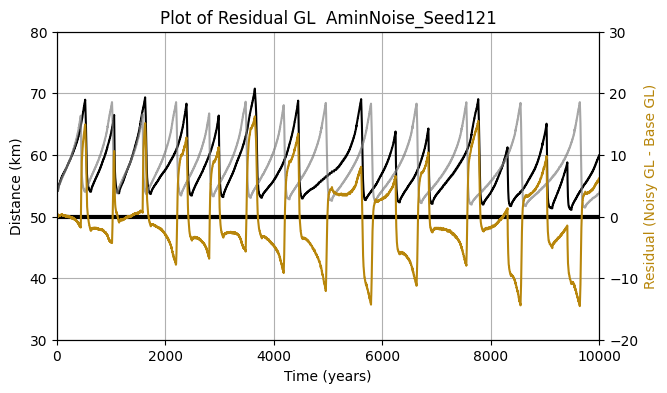

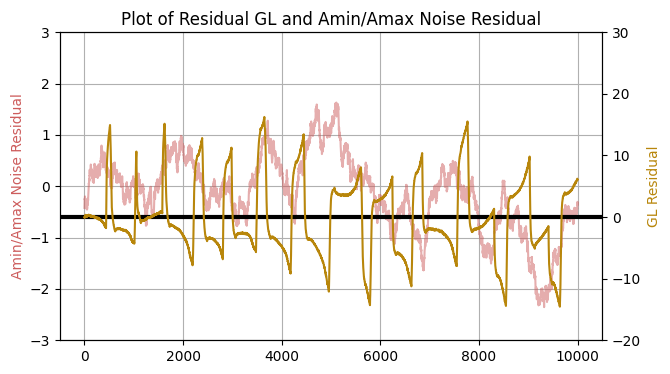

In [368]:
fig, ax = plt.subplots(figsize = (7,4))

# Grounding Line 
ax.plot(timesteps_csv, gl_noisy_interp_yrs, color = 'black', label = 'GL (with Climate Noise)')
ax.plot(timesteps_csv, gl_base_interp_yrs, color = 'gray', label = 'Base Run', alpha = 0.7)

# Residual of Base & Noisy GL
ax2 = ax.twinx()
ax2.axhline(y=0, linewidth = 3, color = 'black')
ax2.plot(timesteps_csv, GL_resid, color = 'darkgoldenrod', label = 'GL residual')

ax.set_xlim(0,10000)
ax.set_ylim(30,80)
ax2.set_ylim(-20,30)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Distance (km)")
ax2.set_ylabel("Residual (Noisy GL - Base GL)", color = 'darkgoldenrod')

ax.grid()
plt.title(f"Plot of Residual GL  {runName}")

# Plot of Residual Climate Noise
fig, ax = plt.subplots(figsize = (7,4))

# AMAX Noise Residual
# ax.plot(time_years, amax_noise_resid, color = 'blue')
# ax.set_ylabel("Amax Noise Residual", color = 'blue')
# plt.title(f"Plot of Residual GL and Amax Residual {runName}")

# AMIN Noise Residual
ax.plot(timesteps_csv, amin_noise_resid, color = 'indianred', alpha = 0.5)
ax.set_ylabel("Amin/Amax Noise Residual", color = 'indianred')
plt.title("Plot of Residual GL and Amin/Amax Noise Residual")

ax2 = ax.twinx()
ax2.axhline(y=0, linewidth = 3, color = 'black')
ax2.plot(timesteps_csv, GL_resid, color = 'darkgoldenrod', label = 'GL residual')
ax2.set_ylabel("GL Residual", color = 'darkgoldenrod')
ax.set_ylim(-3,3)
ax2.set_ylim(-20,30)
ax.grid()


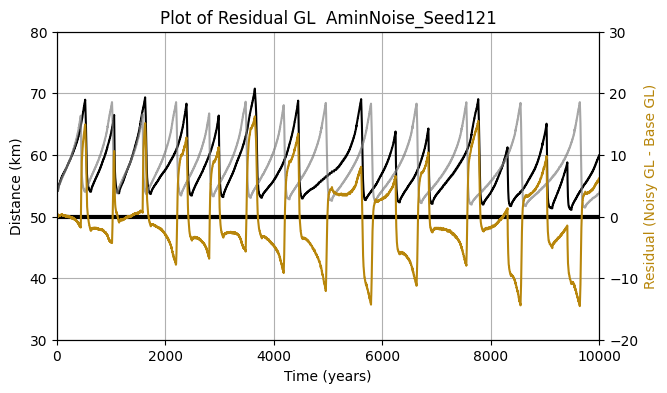

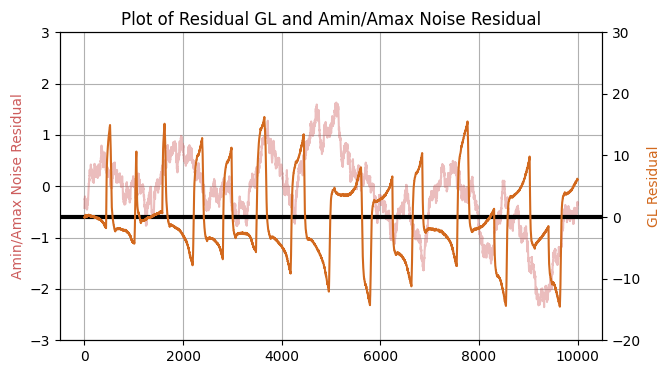

In [369]:
fig, ax = plt.subplots(figsize = (7,4))

# Grounding Line 
ax.plot(timesteps_csv, gl_noisy_interp_yrs, color = 'black', label = 'GL (with Climate Noise)')
ax.plot(timesteps_csv, gl_base_interp_yrs, color = 'gray', label = 'Base Run', alpha = 0.7)

# Residual of Base & Noisy GL
ax2 = ax.twinx()
ax2.axhline(y=0, linewidth = 3, color = 'black')
ax2.plot(timesteps_csv, GL_resid, color = 'darkgoldenrod', label = 'GL residual')

ax.set_xlim(0,10000)
ax.set_ylim(30,80)
ax2.set_ylim(-20,30)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Distance (km)")
ax2.set_ylabel("Residual (Noisy GL - Base GL)", color = 'darkgoldenrod')

ax.grid()
plt.title(f"Plot of Residual GL  {runName}")

# Plot of Residual Climate Noise
fig, ax = plt.subplots(figsize = (7,4))

# AMAX Noise Residual
# ax.plot(time_years, amax_noise_resid, color = 'blue', alpha = 0.4)
# ax.set_ylabel("Amax Noise Residual", color = 'blue')
# plt.title(f"Plot of Residual GL and Amax Residual {runName}")

# AMIN Noise Residual
ax.plot(timesteps_csv, amin_noise_resid, color = 'indianred', alpha = 0.4)
ax.set_ylabel("Amin/Amax Noise Residual", color = 'indianred')
plt.title("Plot of Residual GL and Amin/Amax Noise Residual")

ax2 = ax.twinx()
ax2.axhline(y=0, linewidth = 3, color = 'black')
ax2.plot(timesteps_csv, GL_resid, color = 'chocolate', label = 'GL residual')
ax2.set_ylabel("GL Residual", color = 'chocolate')
ax.set_ylim(-3,3)
ax2.set_ylim(-20,30)
ax.grid()


In [370]:
def find_lag_scipy(x, y, dt=1.0):
    x = x - np.mean(x)
    y = y - np.mean(y)
    corr = correlate(x, y, mode='same', method='fft')
    lags = correlation_lags(len(x), len(y), mode='same') * dt
    lag = lags[np.argmax(corr)]
    return lag, corr, lags

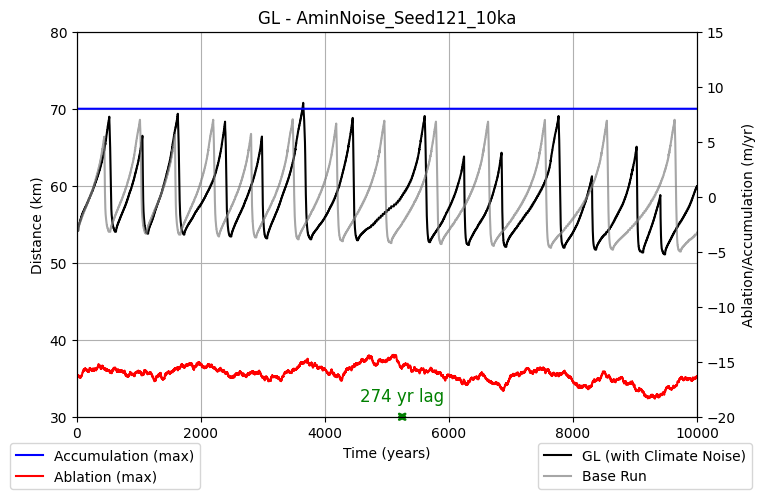

In [371]:
fig, ax = plt.subplots(figsize = (8,5))

# AMAX Lag Calculation
# lag_resid_amax, corr_resid_amax, lags_resid_amax = find_lag_scipy(GL_resid, amax_noise_resid, dt=1.0)
# t_peak = time_years[np.argmax(noisy_amax_series)]

# AMIN Lag Calculation
lag_resid_amin, corr_resid_amin, lags_resid_amin = find_lag_scipy(GL_resid, amin_noise_resid, dt=1.0)
t_peak = timesteps_csv[np.argmax(noisy_amin_series)]

# Grounding Line 
ax.plot(timesteps_csv, gl_noisy_interp_yrs, color = 'black', label = 'GL (with Climate Noise)')
ax.plot(timesteps_csv, gl_base_interp_yrs, color = 'gray', label = 'Base Run', alpha = 0.7)

# Interpolated Noisy Accumulation and Abaltion 
ax2 = ax.twinx()
ax2.plot(timesteps_csv, noisy_amax_series, label = 'Accumulation (max)', color = 'blue')
ax2.plot(timesteps_csv, noisy_amin_series, label = 'Ablation (max)', color = 'red')

# AMAX Lag Arrow
# ax.annotate('', 
#             xy=(t_peak, 30), 
#             xytext=(t_peak + lag_resid_amax, 30), 
#             arrowprops=dict(arrowstyle='<->', color='green', lw=2))
# ax.text(t_peak + lag_resid_amax/2, 32, f"{lag_resid_amax:.0f} yr lag", color='green', ha='center', fontsize = 12)

# AMIN Lag Arrow
ax.annotate('', 
            xy=(t_peak, 30), 
            xytext=(t_peak + lag_resid_amin, 30), 
            arrowprops=dict(arrowstyle='<->', color='green', lw=2))
ax.text(t_peak + lag_resid_amin/2, 32, f"{lag_resid_amin:.0f} yr lag", color='green', ha='center', fontsize = 12)

ax.legend(bbox_to_anchor=(1.1, -0.05))
ax2.legend(bbox_to_anchor=(.21, -0.05))

ax.set_xlim(0,10000)
ax.set_ylim(30,80)
ax2.set_ylim(-20,15)

ax.set_xlabel("Time (years)")
ax.set_ylabel("Distance (km)")
ax2.set_ylabel("Ablation/Accumulation (m/yr)")

plt.title(f"GL - {runName}_{runTime}")
ax.grid()
plt.show()

In [372]:
def find_lag_phys(x, y, dt=1.0, max_lag=500):
    """
    Returns a physically meaningful lag (years) by:
      - detrending mean
      - computing full cross-correlation
      - returning the strongest peak within ±max_lag years around zero
    """
    # detrend & mean-center
    x2 = detrend(x - np.mean(x))
    y2 = detrend(y - np.mean(y))

    corr = correlate(x2, y2, mode='full', method='fft')
    lags = correlation_lags(len(x2), len(y2), mode='full') * dt

    # plot optionally to inspect - caller can do this
    # pick near-zero peak
    mask = np.abs(lags) <= max_lag
    if not np.any(mask):
        raise ValueError("max_lag too small.")
    lag_near0 = lags[mask][np.argmax(corr[mask])]
    return lag_near0, corr, lags

lag = -4999.0 years
lag = 274.0 years


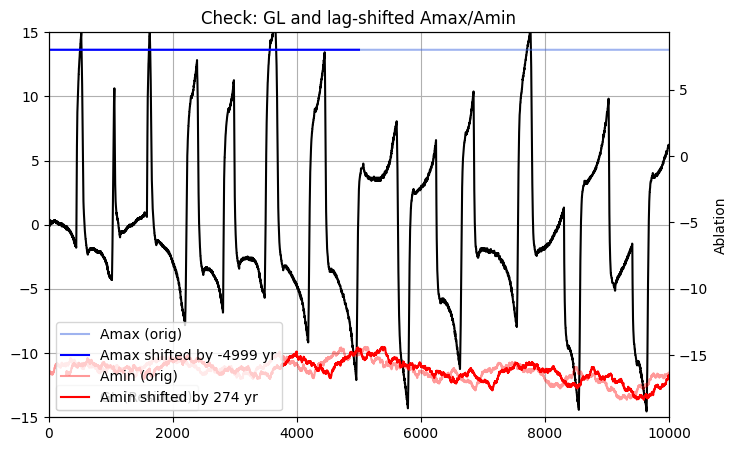

In [373]:
dt = np.mean(np.diff(timesteps_csv))

fig, ax = plt.subplots(figsize = (8,5))
# GL Plot
ax.plot(timesteps_csv, GL_resid, 'k', label='GL (Residual)')

ax2 = ax.twinx()

# AMAX
lag_resid_amax, corr_resid_amax, lags_resid_amax = find_lag_scipy(GL_resid, amax_noise_resid, dt=dt)
print(f"lag = {lag_resid_amax:.1f} years")
ax2.plot(timesteps_csv, noisy_amax_series, 'royalblue', alpha=0.5, label='Amax (orig)')
ax2.plot(timesteps_csv + lag_resid_amax, noisy_amax_series, 'b', alpha=1, label=f'Amax shifted by {lag_resid_amax:.0f} yr')
ax2.set_ylabel("Accumulation")


# AMIN
lag_resid_amin, corr_resid_amin, lags_resid_amin = find_lag_phys(GL_resid, amin_noise_resid, dt=dt, max_lag=600)
print(f"lag = {lag_resid_amin:.1f} years")
ax2.plot(timesteps_csv, noisy_amin_series, 'red', alpha=0.4, label='Amin (orig)')
ax2.plot(timesteps_csv + lag_resid_amin, noisy_amin_series, 'red', alpha=1, label=f'Amin shifted by {lag_resid_amin:.0f} yr')
ax2.set_ylabel("Ablation")

ax.set_xlim(0, 10000)
ax.set_ylim(-15, 15)
ax.legend()
ax2.legend(loc = 3)
ax.grid()
plt.title('Check: GL and lag-shifted Amax/Amin')
plt.show()



# Cross Correlation Plot
# plt.figure(figsize=(5,2))

# # AMAX
# plt.plot(lags_resid_amax, corr_resid_amax)
# plt.axvline(lag_resid_amax, color='orange', linestyle='--')

# # AMIN
# # plt.plot(lags_resid_amin, corr_resid_amin)
# # plt.axvline(lag_resid_amin, color='orange', linestyle='--')

# plt.axvline(0, color='k', linestyle='--', linewidth=0.8)
# plt.xlim(-800, 800)
# plt.xlabel('Lag (years)')
# plt.ylabel('Cross-correlation')
# plt.title('Cross-correlation (detrended)')
# plt.show()

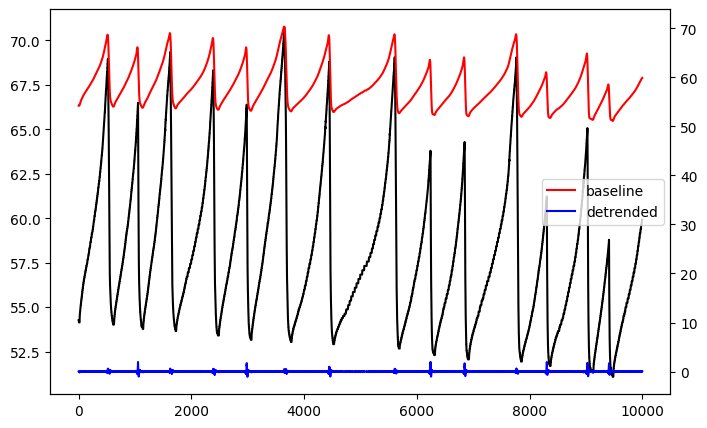

In [374]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(timesteps_csv, gl_noisy_interp_yrs, label='GL_detrended', color='black')

fs = 1  # sampling frequency (1 if your x is just timestep)
cutoff = 0.05  # adjust smaller = smoother baseline
b, a = signal.butter(3, cutoff, btype='lowpass')
baseline = signal.filtfilt(b, a, gl_noisy_interp_yrs)

# Remove baseline
detrended = gl_noisy_interp_yrs - baseline

ax2 = ax.twinx()
ax2.plot(timesteps_csv, baseline, 'r', label='baseline')
ax2.plot(timesteps_csv, detrended, 'b', label='detrended')

ax2.legend()
plt.show()

# Power Spectrum

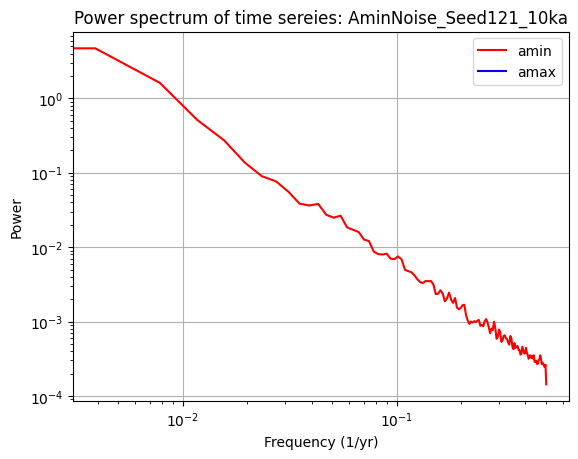

In [375]:
plt.figure()
plt.loglog(freqs_amin1, Pxx_amin1, color = 'red', label = 'amin')
plt.loglog(freqs_amax1, Pxx_amax1, color = 'blue', label = 'amax')
plt.xlabel("Frequency (1/yr)")
plt.ylabel("Power")
plt.title(f"Power spectrum of time sereies: {runName}_{runTime}")
plt.legend()
plt.grid(True)
plt.show()

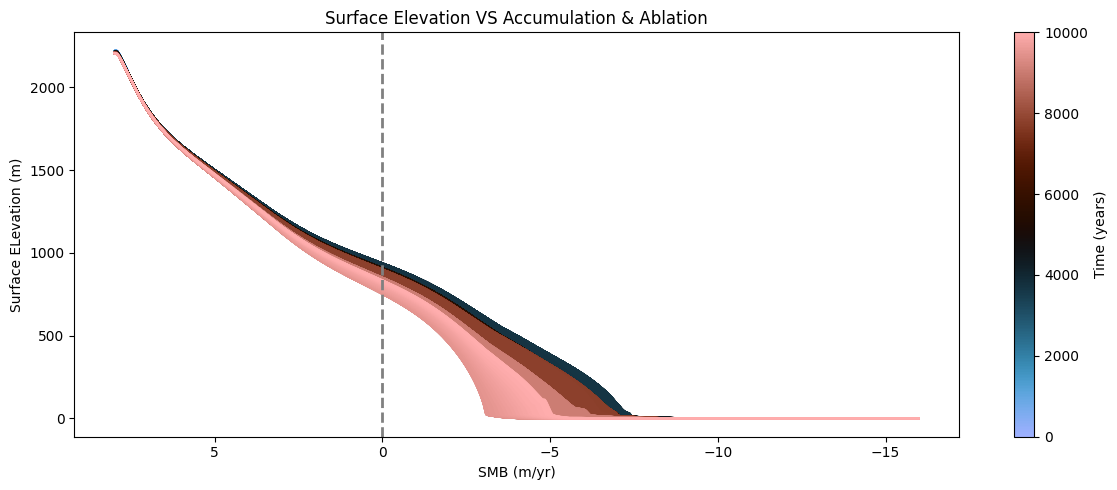

In [376]:
timestepsSMB = sorted(SMB_dict.keys())
smb_profile = SMB_dict[timestepsSMB[0]] 
cmap = cm.berlin

fig,ax  = plt.subplots(figsize=(12,5))


counts = sorted(counter_dict.values())  # all loop counts
sample_counts = counts[::1] 

# make a lookup: loop count → time
loop_to_time = {v: k for k, v in counter_dict.items()}

for j, c in enumerate(sample_counts):
    t = loop_to_time[c]
    surf = surf_dict[t]
    color = cmap(norm(t))
    label = f't={t:.1f}' if j % 5 == 0 else ""
    plt.plot(smb_profile, surf, color=color, label=label)


plt.xlabel("SMB (m/yr)")
plt.ylabel("Surface ELevation (m)")
plt.title("Surface Elevation VS Accumulation & Ablation")
plt.gca().invert_xaxis()
# plt.legend(loc="best", fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, label='Time (years)', ax=plt.gca())
plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)
plt.tight_layout()
plt.show()
# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/SMB_plot_40k_default.svg", format ="svg", bbox_inches='tight')

final_smb = list(SMB_dict.values())[-1]
# print(final_smb)

# Amin & Amax Over Time

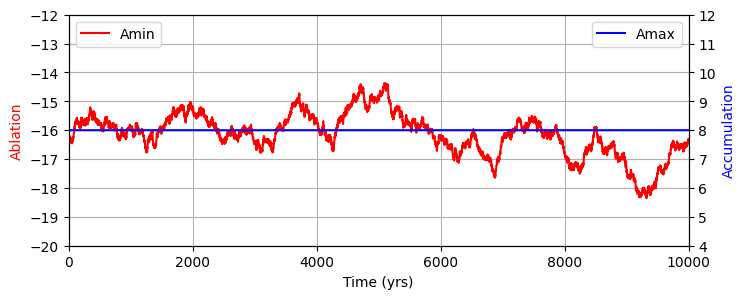

In [377]:
fig, ax = plt.subplots(figsize = (8,3))

ax.plot(timesteps_csv, noisy_amin_series, color = 'red', label = "Amin")
ax.set_ylabel("Ablation", color = 'red')
ax2 = ax.twinx()
ax2.plot(timesteps_csv, noisy_amax_series, color = 'blue', label = 'Amax')
ax2.set_ylabel("Accumulation", color = 'blue')
ax.set_xlabel("Time (yrs)")
ax.legend(loc=2)
ax2.legend(loc=1)


# ax.plot(timesteps2, amin_series2, color = 'red')
# ax2 = ax.twinx()
# ax2.plot(timesteps2, amax_series2, color = 'blue')
ax.set_xlim(0,10000)
ax.set_ylim(-20,-12)
ax2.set_ylim(4,12)
ax.grid()
plt.show()


Text(0.5, 1.0, 'Noise - Seed: 220')

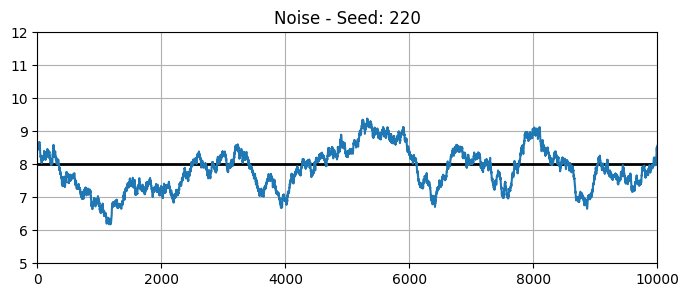

In [378]:
# Testing random number generator noise options
seed = 220
rand = np.random.default_rng(seed)
beta = 2
t_end = 10000

noise = cn.powerlaw_psd_gaussian(beta, t_end, random_state=rand)


noise += 8  # mean offset

fig, ax = plt.subplots(figsize = (8,3))

ax.axhline(y=8, color = 'black', linewidth = 2)
ax.plot(noise)
ax.set_xlim(0,10000)
ax.set_ylim(5,12)
ax.grid()
plt.title(f"Noise - Seed: {seed}")

# Random Tests

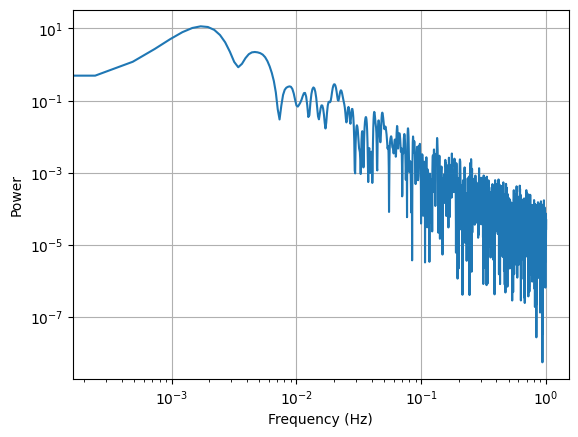

standard dev: 0.7723916756217338
mean: 0.0006784253913261438


In [379]:
rand = np.random.default_rng(7)
beta = 2 # the exponent
samples = 2000 # number of samples to generate
y = cn.powerlaw_psd_gaussian(beta, samples, random_state=rand)

# y *= 1.0

s, f = mlab.psd(y, NFFT=2**13)
plt.loglog(f,s)
plt.grid(True)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()

print(f"standard dev: {np.std(y)}")
print(f"mean: {np.mean(y)}")